rework of ch_9_2_first_nns.ipnynb to make cnns  
utilizing csv instead of loading as images   
4. 15x20 // CNN 2D // 3 - Live Data vs PerfectFam vs StreakMM

# IMPORTS

In [4]:
import random
import pickle
import glob

import random
import ast
import pathlib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# import matplotlib.transforms as transforms

from collections import Counter

from time import time
from time import sleep
from time import strftime
from time import localtime
from tqdm import tqdm

from datetime import date, timedelta, datetime

# from mydecorators import logger, stopwatch

from PIL import Image



In [5]:
import torch
import torch.nn as nn
import torchvision

import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import Dataset

import matplotlib.pyplot as plt



# Read CSV of All Data

In [10]:
df_alldata = pd.read_csv('combined_dataset.csv')
# display(df_alldata)

In [11]:
df_alldata.head()

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,2,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,2,perfectmm_456_1
2,1,1,1,0,1,0,1,0,0,0,...,1,0,0,1,0,1,1,0,2,perfectmm_456_2
3,1,1,1,1,1,1,1,0,1,0,...,0,1,1,0,0,1,0,1,2,perfectmm_456_3
4,1,0,0,0,0,0,0,1,1,1,...,1,0,0,0,1,0,1,1,2,perfectmm_456_4


# Prepare Dataframes
- Remove Live Data (0)  
- Check Labels ...   
=>  
Live Data : 0  
NearPerfectMM : 1    
PerfectMM : 2  
StreakMM : 3  

In [15]:
df_w_live = df_alldata.copy()

# display(df_wo_live)

## Check current labels

In [21]:
orig_labels = list(df_w_live['labels'])

In [23]:
len(orig_labels)

132127

In [25]:
set(orig_labels)
### 0: live_data
### 1: nearperfectmm
### 2: perfectmm
### 3: streakmm

{0, 1, 2, 3}

## Relabel Accordingly
live_data 0 -> 0  
nearperfectmm 1 -> 1  
perfectmm 2 -> 1   
streakmm 3 -> 2

In [29]:
replaced_labels = [1 if x==2 else x for x in orig_labels]
set(replaced_labels)

{0, 1, 3}

In [31]:
replaced_labels = [2 if x==3 else x for x in replaced_labels]
set(replaced_labels)

{0, 1, 2}

In [33]:
df_w_live['labels'] = replaced_labels

In [35]:
set(df_w_live['labels'])

{0, 1, 2}

## Display Current Dataframe

In [41]:
df_w_live[df_w_live['labels']==0].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
90000,1,1,1,0,1,1,1,0,1,0,...,0,1,1,1,0,1,1,0,0,좋은챔프
90001,0,1,0,0,0,0,0,0,0,0,...,1,1,0,0,0,1,1,1,0,진기장판


In [43]:
df_w_live[df_w_live['labels']==0].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
132125,0,0,0,1,1,0,1,1,0,0,...,0,1,0,1,0,1,1,1,0,너가능성잇써
132126,0,1,0,1,0,1,1,0,1,1,...,0,0,0,0,0,1,1,0,0,토꽃


In [45]:
df_w_live[df_w_live['labels']==1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
0,0,0,1,0,0,0,0,0,0,1,...,1,0,0,1,0,0,0,1,1,perfectmm_456_0
1,1,0,1,1,0,0,1,1,0,0,...,1,0,1,0,1,1,1,0,1,perfectmm_456_1


In [47]:
df_w_live[df_w_live['labels']==1].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
59998,1,0,1,0,1,1,1,1,0,0,...,1,1,0,1,1,1,1,1,1,nearperfectmm_457_998
59999,0,1,1,1,0,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,nearperfectmm_457_999


In [49]:
df_w_live[df_w_live['labels']==2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
60000,0,1,0,0,0,0,0,1,1,0,...,1,1,1,1,1,1,1,1,2,streakmm_412_0
60001,1,1,1,1,1,1,0,0,0,0,...,0,1,0,1,1,1,1,1,2,streakmm_412_1


In [53]:
df_w_live[df_w_live['labels']==2].tail(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths
89998,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,2,streakmm_386_998
89999,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,0,0,0,2,streakmm_386_999


In [51]:
df_w_live[df_w_live['labels']==3].head(2)

,0,1,2,3,4,5,6,7,8,9,...,292,293,294,295,296,297,298,299,labels,filepaths


# Create Pytorch Dataset (custom)

## Define Dataset Class

In [58]:
# Custom Dataset Class
## Needs ATLEAST 3 class methods
## __init__, __len__, __getitem__

class RecordsDataset(Dataset):
    # This loads the data and converts it, make data rdy
    def __init__(self, pd_df):
        # load data
        self.df=pd_df
        # extract labels
        self.df_labels=self.df[['labels']]
        # drop non numeric columns to make tutorial simpler, in real life do categorical encoding
        # self.df=df.drop(columns=['Type','Color','Spectral_Class'])
        
        # convert to torch dtypes
        # self.dataset = self.df[[0,1]]
        # self.dataset=torch.tensor(self.df[[i for i in range(300)]].to_numpy()).float()
        self.dataset=torch.tensor(self.df[[str(i) for i in range(300)]].to_numpy()).float()
        # self.dataset = self.df[[str(i) for i in range(10)]]
        
        self.labels=torch.tensor(self.df_labels.to_numpy().reshape(-1))
    
    # This returns the total amount of samples in your Dataset
    def __len__(self):
        return len(self.dataset)
    
    # This returns given an index the i-th sample and label
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]

## Instantiate Dataset Class

In [62]:
all_dataset = RecordsDataset(df_w_live)

## Split Train & Test

In [64]:
train_size = int(0.7 * len(all_dataset))
test_size = len(all_dataset) - train_size
# train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size])

train_alldataset, test_alldataset = torch.utils.data.random_split(all_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(1))
### torch.Generator().manual_seed(42)

In [66]:
train_alldataset
len(train_alldataset)

92488

In [68]:
test_alldataset
len(test_alldataset)

39639

## Create Train & Test all_dataloaders

In [72]:
train_alldataloader = torch.utils.data.DataLoader(train_alldataset, batch_size=32, shuffle=True)

In [74]:
test_alldataloader = torch.utils.data.DataLoader(test_alldataset, batch_size=32, shuffle=False)

### Check Train alldataloader

In [78]:
for images, labels in train_alldataloader:
    break

# images, labels = next(iter(dataloader))

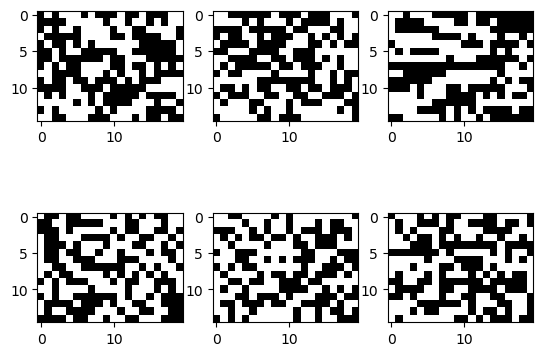

In [80]:
examples = iter(train_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)

# example_data.shape
# example_data[0].reshape(15,20)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [82]:
print(example_targets)

tensor([0, 1, 2, 1, 0, 1, 1, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 0,
        1, 1, 1, 0, 0, 2, 1, 1])


### Check Test alldataloader

In [86]:
for images, labels in test_alldataloader:
    break

# images, labels = next(iter(dataloader))

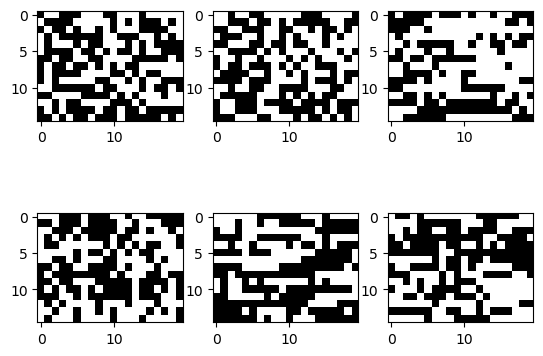

In [90]:
examples = iter(test_alldataloader)
# example_data, example_targets = examples.next()
example_data, example_targets = next(examples)


for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(example_data[i].reshape(15,20), cmap='gray')
    # print(example_targets)
plt.show()

In [99]:
print(example_targets)

tensor([1, 1, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2, 1, 1, 2, 2, 1, 2,
        1, 1, 2, 0, 1, 1, 2, 0])


# Create First CNN
- Live Data vs (PerfectMM & NearPerfectMM) v StreakMM


## Configurations (Hyperparameters)

In [339]:
# Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Hyper-parameters
input_size = 15*20 # originally 348x465 before resize

num_classes = 3


# num_epochs = 1
# num_epochs = 2
# num_epochs = 10
# num_epochs = 20
# num_epochs = 50
# num_epochs = 100
# num_epochs = 300
num_epochs = 500
# num_epochs = 1000

learning_rate = 0.0003

In [341]:
print(device)

mps


## Define Model

In [344]:
###

class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        
        # self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding='same')        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding='same')
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='same')
        # self.conv4 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=2, padding='same')
        
        
        self.fc1 = nn.Linear(64*3*5, 64)
        # self.fc2 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, num_classes)
        
        self.drop1 = nn.Dropout(p=0.3)
        # self.drop2 = nn.Dropout(p=0.3)
        
        ### crossentropyloss already entails softmax -> softmax not needed additionally
        # self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # print(x.shape)       # batch_size, 300
        
        x = x.reshape(-1, 1, 15,20)
        # print(x.shape)      # batch_size, 1, 15, 20
        
        x = F.relu(self.conv1(x))   # -> batch_size, 256, 15, 20
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 256, 7, 10
        # print(x.shape)
        x = F.relu(self.conv2(x))   # -> batch_size, 128, 7, 10
        # print(x.shape)
        x = self.pool(x)            # -> batch_size, 128, 3, 5
        # print(x.shape)
        x = F.relu(self.conv3(x))   # -> batch_size, 64, 3, 5
        # print(x.shape)
        # x = self.pool(x)            # -> batch_size, 64, 1, 2
        # print(x.shape)
        
        # x = F.relu(self.conv4(x))   # -> batch_size, 32, 3, 5
        # print(x.shape)
        
        x = torch.flatten(x, 1)     # -> batch_size, 64
        # print(x.shape)
        x = self.drop1(x)
        
        x = F.relu(self.fc1(x))     # -> batch_size, 32
        # x = self.drop1(x)
        # print(x.shape)
        
        x = self.fc2(x)             # -> batch_size, num_classes(=4)
        # print(x.shape)
        
        # x = self.fc3(x)             # -> batch_size, num_classes(=4)
        # print(x.shape)
        
        # x = self.softmax(x)
        # print(x.shape)
        
        return x
    
    
### apprx 12 seconds per epoch to train (mps, w/ 1 dropout, Adam)
### 50 epochs, initial loss: 0.554, final loss: 0.158 // 
### 100 epochs, initial loss: 0.556, final loss: 0.084 // 
### 300 epochs, initial loss: 0.552, final loss: 0.020 // 
### 500 epochs, initial loss: 0.552, final loss: 0.013 // 

## Train First CNN

In [349]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

n_total_steps = len(train_alldataloader)
for epoch in tqdm(range(num_epochs)):

    running_loss = 0.0

    for i, (images, labels) in enumerate(train_alldataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        running_loss += loss.item()

    print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

print('Finished Training')
# torch.save(model.state_dict(), PATH)

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))




### apprx 10 seconds per epoch to train (mps, w/ 1 dropout, Adam, softmax)



2024-05-21 22:26:03




  0%|          | 1/500 [00:11<1:32:36, 11.13s/it]

[1] loss: 0.552


  0%|          | 2/500 [00:22<1:31:24, 11.01s/it]

[2] loss: 0.521


  1%|          | 3/500 [00:32<1:29:16, 10.78s/it]

[3] loss: 0.512


  1%|          | 4/500 [00:42<1:27:57, 10.64s/it]

[4] loss: 0.507


  1%|          | 5/500 [00:53<1:27:16, 10.58s/it]

[5] loss: 0.505


  1%|          | 6/500 [01:04<1:27:04, 10.58s/it]

[6] loss: 0.502


  1%|▏         | 7/500 [01:14<1:26:33, 10.53s/it]

[7] loss: 0.499


  2%|▏         | 8/500 [01:25<1:27:04, 10.62s/it]

[8] loss: 0.495


  2%|▏         | 9/500 [01:35<1:26:39, 10.59s/it]

[9] loss: 0.490


  2%|▏         | 10/500 [01:46<1:26:17, 10.57s/it]

[10] loss: 0.484


  2%|▏         | 11/500 [01:56<1:25:56, 10.54s/it]

[11] loss: 0.476


  2%|▏         | 12/500 [02:07<1:25:30, 10.51s/it]

[12] loss: 0.467


  3%|▎         | 13/500 [02:17<1:25:03, 10.48s/it]

[13] loss: 0.457


  3%|▎         | 14/500 [02:28<1:25:31, 10.56s/it]

[14] loss: 0.445


  3%|▎         | 15/500 [02:38<1:25:07, 10.53s/it]

[15] loss: 0.433


  3%|▎         | 16/500 [02:49<1:24:45, 10.51s/it]

[16] loss: 0.421


  3%|▎         | 17/500 [02:59<1:24:24, 10.49s/it]

[17] loss: 0.408


  4%|▎         | 18/500 [03:10<1:24:05, 10.47s/it]

[18] loss: 0.394


  4%|▍         | 19/500 [03:20<1:24:06, 10.49s/it]

[19] loss: 0.381


  4%|▍         | 20/500 [03:31<1:23:51, 10.48s/it]

[20] loss: 0.368


  4%|▍         | 21/500 [03:41<1:23:31, 10.46s/it]

[21] loss: 0.354


  4%|▍         | 22/500 [03:52<1:23:23, 10.47s/it]

[22] loss: 0.340


  5%|▍         | 23/500 [04:02<1:23:17, 10.48s/it]

[23] loss: 0.328


  5%|▍         | 24/500 [04:13<1:23:00, 10.46s/it]

[24] loss: 0.315


  5%|▌         | 25/500 [04:23<1:23:15, 10.52s/it]

[25] loss: 0.303


  5%|▌         | 26/500 [04:34<1:23:38, 10.59s/it]

[26] loss: 0.293


  5%|▌         | 27/500 [04:44<1:23:00, 10.53s/it]

[27] loss: 0.281


  6%|▌         | 28/500 [04:55<1:22:52, 10.54s/it]

[28] loss: 0.273


  6%|▌         | 29/500 [05:05<1:22:27, 10.50s/it]

[29] loss: 0.260


  6%|▌         | 30/500 [05:16<1:22:05, 10.48s/it]

[30] loss: 0.251


  6%|▌         | 31/500 [05:27<1:23:14, 10.65s/it]

[31] loss: 0.242


  6%|▋         | 32/500 [05:38<1:23:42, 10.73s/it]

[32] loss: 0.234


  7%|▋         | 33/500 [05:48<1:22:49, 10.64s/it]

[33] loss: 0.225


  7%|▋         | 34/500 [05:59<1:22:08, 10.58s/it]

[34] loss: 0.218


  7%|▋         | 35/500 [06:09<1:21:30, 10.52s/it]

[35] loss: 0.209


  7%|▋         | 36/500 [06:20<1:21:40, 10.56s/it]

[36] loss: 0.204


  7%|▋         | 37/500 [06:30<1:21:41, 10.59s/it]

[37] loss: 0.198


  8%|▊         | 38/500 [06:41<1:21:11, 10.54s/it]

[38] loss: 0.191


  8%|▊         | 39/500 [06:52<1:21:45, 10.64s/it]

[39] loss: 0.184


  8%|▊         | 40/500 [07:02<1:20:57, 10.56s/it]

[40] loss: 0.179


  8%|▊         | 41/500 [07:12<1:20:24, 10.51s/it]

[41] loss: 0.172


  8%|▊         | 42/500 [07:23<1:20:38, 10.57s/it]

[42] loss: 0.167


  9%|▊         | 43/500 [07:33<1:20:11, 10.53s/it]

[43] loss: 0.165


  9%|▉         | 44/500 [07:44<1:19:42, 10.49s/it]

[44] loss: 0.158


  9%|▉         | 45/500 [07:54<1:19:36, 10.50s/it]

[45] loss: 0.154


  9%|▉         | 46/500 [08:05<1:19:25, 10.50s/it]

[46] loss: 0.150


  9%|▉         | 47/500 [08:15<1:18:59, 10.46s/it]

[47] loss: 0.145


 10%|▉         | 48/500 [08:26<1:20:10, 10.64s/it]

[48] loss: 0.142


 10%|▉         | 49/500 [08:37<1:19:27, 10.57s/it]

[49] loss: 0.140


 10%|█         | 50/500 [08:47<1:18:56, 10.52s/it]

[50] loss: 0.135


 10%|█         | 51/500 [08:59<1:21:47, 10.93s/it]

[51] loss: 0.134


 10%|█         | 52/500 [09:10<1:22:48, 11.09s/it]

[52] loss: 0.130


 11%|█         | 53/500 [09:22<1:24:25, 11.33s/it]

[53] loss: 0.127


 11%|█         | 54/500 [09:34<1:23:52, 11.28s/it]

[54] loss: 0.123


 11%|█         | 55/500 [09:44<1:21:42, 11.02s/it]

[55] loss: 0.122


 11%|█         | 56/500 [09:54<1:20:20, 10.86s/it]

[56] loss: 0.120


 11%|█▏        | 57/500 [10:05<1:19:48, 10.81s/it]

[57] loss: 0.116


 12%|█▏        | 58/500 [10:16<1:18:59, 10.72s/it]

[58] loss: 0.115


 12%|█▏        | 59/500 [10:26<1:18:43, 10.71s/it]

[59] loss: 0.110


 12%|█▏        | 60/500 [10:37<1:18:02, 10.64s/it]

[60] loss: 0.109


 12%|█▏        | 61/500 [10:48<1:18:22, 10.71s/it]

[61] loss: 0.109


 12%|█▏        | 62/500 [10:58<1:17:26, 10.61s/it]

[62] loss: 0.106


 13%|█▎        | 63/500 [11:08<1:16:42, 10.53s/it]

[63] loss: 0.105


 13%|█▎        | 64/500 [11:19<1:16:05, 10.47s/it]

[64] loss: 0.104


 13%|█▎        | 65/500 [11:29<1:15:59, 10.48s/it]

[65] loss: 0.101


 13%|█▎        | 66/500 [11:40<1:15:28, 10.43s/it]

[66] loss: 0.101


 13%|█▎        | 67/500 [11:50<1:15:01, 10.40s/it]

[67] loss: 0.098


 14%|█▎        | 68/500 [12:00<1:14:51, 10.40s/it]

[68] loss: 0.095


 14%|█▍        | 69/500 [12:11<1:14:36, 10.39s/it]

[69] loss: 0.097


 14%|█▍        | 70/500 [12:21<1:14:20, 10.37s/it]

[70] loss: 0.092


 14%|█▍        | 71/500 [12:31<1:14:07, 10.37s/it]

[71] loss: 0.092


 14%|█▍        | 72/500 [12:42<1:13:53, 10.36s/it]

[72] loss: 0.091


 15%|█▍        | 73/500 [12:52<1:13:38, 10.35s/it]

[73] loss: 0.088


 15%|█▍        | 74/500 [13:02<1:13:45, 10.39s/it]

[74] loss: 0.088


 15%|█▌        | 75/500 [13:13<1:14:33, 10.53s/it]

[75] loss: 0.087


 15%|█▌        | 76/500 [13:24<1:14:29, 10.54s/it]

[76] loss: 0.085


 15%|█▌        | 77/500 [13:35<1:15:37, 10.73s/it]

[77] loss: 0.084


 16%|█▌        | 78/500 [13:45<1:14:37, 10.61s/it]

[78] loss: 0.082


 16%|█▌        | 79/500 [13:56<1:14:05, 10.56s/it]

[79] loss: 0.082


 16%|█▌        | 80/500 [14:06<1:13:33, 10.51s/it]

[80] loss: 0.082


 16%|█▌        | 81/500 [14:17<1:13:06, 10.47s/it]

[81] loss: 0.079


 16%|█▋        | 82/500 [14:27<1:13:13, 10.51s/it]

[82] loss: 0.082


 17%|█▋        | 83/500 [14:38<1:12:56, 10.49s/it]

[83] loss: 0.078


 17%|█▋        | 84/500 [14:48<1:12:49, 10.50s/it]

[84] loss: 0.076


 17%|█▋        | 85/500 [14:59<1:12:43, 10.51s/it]

[85] loss: 0.077


 17%|█▋        | 86/500 [15:09<1:12:16, 10.48s/it]

[86] loss: 0.076


 17%|█▋        | 87/500 [15:20<1:12:27, 10.53s/it]

[87] loss: 0.076


 18%|█▊        | 88/500 [15:30<1:12:30, 10.56s/it]

[88] loss: 0.073


 18%|█▊        | 89/500 [15:41<1:11:57, 10.51s/it]

[89] loss: 0.073


 18%|█▊        | 90/500 [15:51<1:11:34, 10.47s/it]

[90] loss: 0.072


 18%|█▊        | 91/500 [16:02<1:11:10, 10.44s/it]

[91] loss: 0.070


 18%|█▊        | 92/500 [16:12<1:10:51, 10.42s/it]

[92] loss: 0.071


 19%|█▊        | 93/500 [16:22<1:11:04, 10.48s/it]

[93] loss: 0.071


 19%|█▉        | 94/500 [16:33<1:10:44, 10.46s/it]

[94] loss: 0.070


 19%|█▉        | 95/500 [16:43<1:10:26, 10.44s/it]

[95] loss: 0.069


 19%|█▉        | 96/500 [16:54<1:10:12, 10.43s/it]

[96] loss: 0.067


 19%|█▉        | 97/500 [17:04<1:10:12, 10.45s/it]

[97] loss: 0.068


 20%|█▉        | 98/500 [17:15<1:09:49, 10.42s/it]

[98] loss: 0.065


 20%|█▉        | 99/500 [17:25<1:09:57, 10.47s/it]

[99] loss: 0.066


 20%|██        | 100/500 [17:35<1:09:35, 10.44s/it]

[100] loss: 0.066


 20%|██        | 101/500 [17:46<1:09:16, 10.42s/it]

[101] loss: 0.065


 20%|██        | 102/500 [17:56<1:09:14, 10.44s/it]

[102] loss: 0.065


 21%|██        | 103/500 [18:07<1:09:01, 10.43s/it]

[103] loss: 0.062


 21%|██        | 104/500 [18:17<1:08:40, 10.40s/it]

[104] loss: 0.064


 21%|██        | 105/500 [18:28<1:09:04, 10.49s/it]

[105] loss: 0.064


 21%|██        | 106/500 [18:38<1:08:55, 10.50s/it]

[106] loss: 0.061


 21%|██▏       | 107/500 [18:49<1:08:27, 10.45s/it]

[107] loss: 0.061


 22%|██▏       | 108/500 [18:59<1:08:18, 10.46s/it]

[108] loss: 0.062


 22%|██▏       | 109/500 [19:09<1:07:48, 10.41s/it]

[109] loss: 0.058


 22%|██▏       | 110/500 [19:20<1:07:55, 10.45s/it]

[110] loss: 0.059


 22%|██▏       | 111/500 [19:31<1:07:56, 10.48s/it]

[111] loss: 0.058


 22%|██▏       | 112/500 [19:41<1:07:32, 10.44s/it]

[112] loss: 0.060


 23%|██▎       | 113/500 [19:51<1:07:16, 10.43s/it]

[113] loss: 0.057


 23%|██▎       | 114/500 [20:02<1:07:04, 10.43s/it]

[114] loss: 0.059


 23%|██▎       | 115/500 [20:12<1:06:53, 10.42s/it]

[115] loss: 0.057


 23%|██▎       | 116/500 [20:23<1:07:57, 10.62s/it]

[116] loss: 0.056


 23%|██▎       | 117/500 [20:34<1:08:07, 10.67s/it]

[117] loss: 0.056


 24%|██▎       | 118/500 [20:44<1:07:20, 10.58s/it]

[118] loss: 0.054


 24%|██▍       | 119/500 [20:55<1:06:50, 10.53s/it]

[119] loss: 0.055


 24%|██▍       | 120/500 [21:05<1:06:26, 10.49s/it]

[120] loss: 0.053


 24%|██▍       | 121/500 [21:15<1:05:59, 10.45s/it]

[121] loss: 0.053


 24%|██▍       | 122/500 [21:26<1:06:18, 10.53s/it]

[122] loss: 0.053


 25%|██▍       | 123/500 [21:37<1:05:59, 10.50s/it]

[123] loss: 0.054


 25%|██▍       | 124/500 [21:47<1:05:38, 10.47s/it]

[124] loss: 0.053


 25%|██▌       | 125/500 [21:58<1:05:25, 10.47s/it]

[125] loss: 0.052


 25%|██▌       | 126/500 [22:08<1:05:05, 10.44s/it]

[126] loss: 0.051


 25%|██▌       | 127/500 [22:18<1:04:48, 10.42s/it]

[127] loss: 0.051


 26%|██▌       | 128/500 [22:29<1:05:05, 10.50s/it]

[128] loss: 0.050


 26%|██▌       | 129/500 [22:39<1:04:51, 10.49s/it]

[129] loss: 0.050


 26%|██▌       | 130/500 [22:50<1:04:38, 10.48s/it]

[130] loss: 0.052


 26%|██▌       | 131/500 [23:00<1:04:11, 10.44s/it]

[131] loss: 0.052


 26%|██▋       | 132/500 [23:11<1:03:51, 10.41s/it]

[132] loss: 0.049


 27%|██▋       | 133/500 [23:21<1:03:52, 10.44s/it]

[133] loss: 0.049


 27%|██▋       | 134/500 [23:32<1:03:46, 10.46s/it]

[134] loss: 0.050


 27%|██▋       | 135/500 [23:42<1:03:31, 10.44s/it]

[135] loss: 0.048


 27%|██▋       | 136/500 [23:52<1:03:23, 10.45s/it]

[136] loss: 0.048


 27%|██▋       | 137/500 [24:03<1:03:07, 10.43s/it]

[137] loss: 0.050


 28%|██▊       | 138/500 [24:13<1:02:49, 10.41s/it]

[138] loss: 0.047


 28%|██▊       | 139/500 [24:24<1:03:12, 10.50s/it]

[139] loss: 0.047


 28%|██▊       | 140/500 [24:35<1:03:14, 10.54s/it]

[140] loss: 0.047


 28%|██▊       | 141/500 [24:45<1:02:47, 10.49s/it]

[141] loss: 0.047


 28%|██▊       | 142/500 [24:55<1:02:27, 10.47s/it]

[142] loss: 0.046


 29%|██▊       | 143/500 [25:06<1:02:24, 10.49s/it]

[143] loss: 0.046


 29%|██▉       | 144/500 [25:16<1:02:04, 10.46s/it]

[144] loss: 0.045


 29%|██▉       | 145/500 [25:27<1:02:32, 10.57s/it]

[145] loss: 0.045


 29%|██▉       | 146/500 [25:37<1:02:02, 10.51s/it]

[146] loss: 0.045


 29%|██▉       | 147/500 [25:48<1:01:36, 10.47s/it]

[147] loss: 0.046


 30%|██▉       | 148/500 [25:58<1:01:29, 10.48s/it]

[148] loss: 0.044


 30%|██▉       | 149/500 [26:09<1:01:04, 10.44s/it]

[149] loss: 0.043


 30%|███       | 150/500 [26:19<1:01:07, 10.48s/it]

[150] loss: 0.045


 30%|███       | 151/500 [26:30<1:00:44, 10.44s/it]

[151] loss: 0.041


 30%|███       | 152/500 [26:40<1:01:12, 10.55s/it]

[152] loss: 0.045


 31%|███       | 153/500 [26:51<1:00:54, 10.53s/it]

[153] loss: 0.041


 31%|███       | 154/500 [27:01<1:00:26, 10.48s/it]

[154] loss: 0.044


 31%|███       | 155/500 [27:12<1:00:03, 10.44s/it]

[155] loss: 0.043


 31%|███       | 156/500 [27:22<1:00:02, 10.47s/it]

[156] loss: 0.043


 31%|███▏      | 157/500 [27:33<1:00:00, 10.50s/it]

[157] loss: 0.041


 32%|███▏      | 158/500 [27:43<59:40, 10.47s/it]  

[158] loss: 0.041


 32%|███▏      | 159/500 [27:54<59:34, 10.48s/it]

[159] loss: 0.041


 32%|███▏      | 160/500 [28:04<59:21, 10.47s/it]

[160] loss: 0.041


 32%|███▏      | 161/500 [28:15<59:03, 10.45s/it]

[161] loss: 0.040


 32%|███▏      | 162/500 [28:25<59:13, 10.51s/it]

[162] loss: 0.041


 33%|███▎      | 163/500 [28:36<58:56, 10.49s/it]

[163] loss: 0.042


 33%|███▎      | 164/500 [28:46<58:32, 10.45s/it]

[164] loss: 0.042


 33%|███▎      | 165/500 [28:56<58:17, 10.44s/it]

[165] loss: 0.039


 33%|███▎      | 166/500 [29:07<58:04, 10.43s/it]

[166] loss: 0.040


 33%|███▎      | 167/500 [29:17<57:44, 10.40s/it]

[167] loss: 0.039


 34%|███▎      | 168/500 [29:28<57:48, 10.45s/it]

[168] loss: 0.040


 34%|███▍      | 169/500 [29:38<57:30, 10.43s/it]

[169] loss: 0.041


 34%|███▍      | 170/500 [29:48<57:13, 10.41s/it]

[170] loss: 0.039


 34%|███▍      | 171/500 [29:59<57:04, 10.41s/it]

[171] loss: 0.039


 34%|███▍      | 172/500 [30:10<57:26, 10.51s/it]

[172] loss: 0.037


 35%|███▍      | 173/500 [30:20<57:18, 10.52s/it]

[173] loss: 0.039


 35%|███▍      | 174/500 [30:31<57:06, 10.51s/it]

[174] loss: 0.037


 35%|███▌      | 175/500 [30:41<56:45, 10.48s/it]

[175] loss: 0.037


 35%|███▌      | 176/500 [30:52<56:38, 10.49s/it]

[176] loss: 0.037


 35%|███▌      | 177/500 [31:02<56:12, 10.44s/it]

[177] loss: 0.037


 36%|███▌      | 178/500 [31:12<55:54, 10.42s/it]

[178] loss: 0.037


 36%|███▌      | 179/500 [31:23<56:01, 10.47s/it]

[179] loss: 0.038


 36%|███▌      | 180/500 [31:33<56:09, 10.53s/it]

[180] loss: 0.036


 36%|███▌      | 181/500 [31:44<55:47, 10.49s/it]

[181] loss: 0.036


 36%|███▋      | 182/500 [31:54<55:32, 10.48s/it]

[182] loss: 0.037


 37%|███▋      | 183/500 [32:05<55:08, 10.44s/it]

[183] loss: 0.038


 37%|███▋      | 184/500 [32:15<54:52, 10.42s/it]

[184] loss: 0.036


 37%|███▋      | 185/500 [32:26<55:06, 10.50s/it]

[185] loss: 0.035


 37%|███▋      | 186/500 [32:36<54:48, 10.47s/it]

[186] loss: 0.034


 37%|███▋      | 187/500 [32:47<54:27, 10.44s/it]

[187] loss: 0.035


 38%|███▊      | 188/500 [32:57<54:14, 10.43s/it]

[188] loss: 0.034


 38%|███▊      | 189/500 [33:07<54:02, 10.43s/it]

[189] loss: 0.034


 38%|███▊      | 190/500 [33:18<53:45, 10.40s/it]

[190] loss: 0.034


 38%|███▊      | 191/500 [33:28<54:04, 10.50s/it]

[191] loss: 0.033


 38%|███▊      | 192/500 [33:39<53:44, 10.47s/it]

[192] loss: 0.034


 39%|███▊      | 193/500 [33:49<53:29, 10.45s/it]

[193] loss: 0.034


 39%|███▉      | 194/500 [34:00<53:13, 10.44s/it]

[194] loss: 0.036


 39%|███▉      | 195/500 [34:10<53:30, 10.53s/it]

[195] loss: 0.033


 39%|███▉      | 196/500 [34:22<54:48, 10.82s/it]

[196] loss: 0.034


 39%|███▉      | 197/500 [34:33<55:28, 10.99s/it]

[197] loss: 0.034


 40%|███▉      | 198/500 [34:44<54:33, 10.84s/it]

[198] loss: 0.032


 40%|███▉      | 199/500 [34:54<53:56, 10.75s/it]

[199] loss: 0.034


 40%|████      | 200/500 [35:05<53:14, 10.65s/it]

[200] loss: 0.033


 40%|████      | 201/500 [35:15<52:36, 10.56s/it]

[201] loss: 0.034


 40%|████      | 202/500 [35:26<52:21, 10.54s/it]

[202] loss: 0.033


 41%|████      | 203/500 [35:36<52:14, 10.55s/it]

[203] loss: 0.031


 41%|████      | 204/500 [35:47<51:54, 10.52s/it]

[204] loss: 0.032


 41%|████      | 205/500 [35:57<51:37, 10.50s/it]

[205] loss: 0.033


 41%|████      | 206/500 [36:07<51:12, 10.45s/it]

[206] loss: 0.031


 41%|████▏     | 207/500 [36:18<50:58, 10.44s/it]

[207] loss: 0.034


 42%|████▏     | 208/500 [36:28<51:08, 10.51s/it]

[208] loss: 0.031


 42%|████▏     | 209/500 [36:39<50:47, 10.47s/it]

[209] loss: 0.032


 42%|████▏     | 210/500 [36:49<50:30, 10.45s/it]

[210] loss: 0.032


 42%|████▏     | 211/500 [37:00<50:14, 10.43s/it]

[211] loss: 0.030


 42%|████▏     | 212/500 [37:10<49:55, 10.40s/it]

[212] loss: 0.032


 43%|████▎     | 213/500 [37:21<50:04, 10.47s/it]

[213] loss: 0.030


 43%|████▎     | 214/500 [37:31<49:52, 10.46s/it]

[214] loss: 0.031


 43%|████▎     | 215/500 [37:41<49:31, 10.43s/it]

[215] loss: 0.030


 43%|████▎     | 216/500 [37:52<49:22, 10.43s/it]

[216] loss: 0.028


 43%|████▎     | 217/500 [38:02<49:13, 10.44s/it]

[217] loss: 0.032


 44%|████▎     | 218/500 [38:13<48:54, 10.41s/it]

[218] loss: 0.029


 44%|████▍     | 219/500 [38:23<48:58, 10.46s/it]

[219] loss: 0.028


 44%|████▍     | 220/500 [38:34<48:48, 10.46s/it]

[220] loss: 0.033


 44%|████▍     | 221/500 [38:44<48:31, 10.43s/it]

[221] loss: 0.029


 44%|████▍     | 222/500 [38:54<48:25, 10.45s/it]

[222] loss: 0.029


 45%|████▍     | 223/500 [39:05<48:07, 10.42s/it]

[223] loss: 0.029


 45%|████▍     | 224/500 [39:15<48:00, 10.44s/it]

[224] loss: 0.031


 45%|████▌     | 225/500 [39:26<48:15, 10.53s/it]

[225] loss: 0.028


 45%|████▌     | 226/500 [39:36<47:54, 10.49s/it]

[226] loss: 0.030


 45%|████▌     | 227/500 [39:47<47:34, 10.46s/it]

[227] loss: 0.029


 46%|████▌     | 228/500 [39:57<47:19, 10.44s/it]

[228] loss: 0.032


 46%|████▌     | 229/500 [40:08<46:59, 10.41s/it]

[229] loss: 0.027


 46%|████▌     | 230/500 [40:18<46:48, 10.40s/it]

[230] loss: 0.029


 46%|████▌     | 231/500 [40:29<46:58, 10.48s/it]

[231] loss: 0.030


 46%|████▋     | 232/500 [40:39<46:41, 10.45s/it]

[232] loss: 0.028


 47%|████▋     | 233/500 [40:49<46:32, 10.46s/it]

[233] loss: 0.030


 47%|████▋     | 234/500 [41:00<46:14, 10.43s/it]

[234] loss: 0.028


 47%|████▋     | 235/500 [41:10<46:06, 10.44s/it]

[235] loss: 0.028


 47%|████▋     | 236/500 [41:21<46:18, 10.52s/it]

[236] loss: 0.028


 47%|████▋     | 237/500 [41:32<46:12, 10.54s/it]

[237] loss: 0.029


 48%|████▊     | 238/500 [41:42<45:46, 10.48s/it]

[238] loss: 0.030


 48%|████▊     | 239/500 [41:52<45:32, 10.47s/it]

[239] loss: 0.026


 48%|████▊     | 240/500 [42:03<45:19, 10.46s/it]

[240] loss: 0.027


 48%|████▊     | 241/500 [42:13<44:57, 10.42s/it]

[241] loss: 0.030


 48%|████▊     | 242/500 [42:24<45:14, 10.52s/it]

[242] loss: 0.027


 49%|████▊     | 243/500 [42:34<45:03, 10.52s/it]

[243] loss: 0.027


 49%|████▉     | 244/500 [42:45<44:39, 10.47s/it]

[244] loss: 0.027


 49%|████▉     | 245/500 [42:55<44:29, 10.47s/it]

[245] loss: 0.027


 49%|████▉     | 246/500 [43:06<44:12, 10.44s/it]

[246] loss: 0.029


 49%|████▉     | 247/500 [43:16<43:52, 10.41s/it]

[247] loss: 0.028


 50%|████▉     | 248/500 [43:27<44:04, 10.49s/it]

[248] loss: 0.025


 50%|████▉     | 249/500 [43:37<43:46, 10.46s/it]

[249] loss: 0.026


 50%|█████     | 250/500 [43:47<43:31, 10.44s/it]

[250] loss: 0.026


 50%|█████     | 251/500 [43:58<43:17, 10.43s/it]

[251] loss: 0.028


 50%|█████     | 252/500 [44:08<43:00, 10.41s/it]

[252] loss: 0.025


 51%|█████     | 253/500 [44:19<43:01, 10.45s/it]

[253] loss: 0.028


 51%|█████     | 254/500 [44:30<43:23, 10.58s/it]

[254] loss: 0.025


 51%|█████     | 255/500 [44:40<42:59, 10.53s/it]

[255] loss: 0.026


 51%|█████     | 256/500 [44:50<42:40, 10.50s/it]

[256] loss: 0.025


 51%|█████▏    | 257/500 [45:01<42:21, 10.46s/it]

[257] loss: 0.027


 52%|█████▏    | 258/500 [45:11<42:05, 10.43s/it]

[258] loss: 0.026


 52%|█████▏    | 259/500 [45:22<42:09, 10.50s/it]

[259] loss: 0.024


 52%|█████▏    | 260/500 [45:32<42:04, 10.52s/it]

[260] loss: 0.026


 52%|█████▏    | 261/500 [45:43<41:42, 10.47s/it]

[261] loss: 0.026


 52%|█████▏    | 262/500 [45:53<41:28, 10.45s/it]

[262] loss: 0.027


 53%|█████▎    | 263/500 [46:04<41:16, 10.45s/it]

[263] loss: 0.025


 53%|█████▎    | 264/500 [46:14<40:59, 10.42s/it]

[264] loss: 0.025


 53%|█████▎    | 265/500 [46:25<41:07, 10.50s/it]

[265] loss: 0.027


 53%|█████▎    | 266/500 [46:35<40:56, 10.50s/it]

[266] loss: 0.024


 53%|█████▎    | 267/500 [46:46<40:36, 10.46s/it]

[267] loss: 0.028


 54%|█████▎    | 268/500 [46:56<40:29, 10.47s/it]

[268] loss: 0.023


 54%|█████▍    | 269/500 [47:06<40:08, 10.43s/it]

[269] loss: 0.027


 54%|█████▍    | 270/500 [47:17<39:53, 10.41s/it]

[270] loss: 0.025


 54%|█████▍    | 271/500 [47:28<40:14, 10.55s/it]

[271] loss: 0.026


 54%|█████▍    | 272/500 [47:38<39:52, 10.49s/it]

[272] loss: 0.025


 55%|█████▍    | 273/500 [47:48<39:34, 10.46s/it]

[273] loss: 0.024


 55%|█████▍    | 274/500 [47:59<39:52, 10.59s/it]

[274] loss: 0.025


 55%|█████▌    | 275/500 [48:10<39:24, 10.51s/it]

[275] loss: 0.026


 55%|█████▌    | 276/500 [48:20<39:16, 10.52s/it]

[276] loss: 0.026


 55%|█████▌    | 277/500 [48:31<39:06, 10.52s/it]

[277] loss: 0.023


 56%|█████▌    | 278/500 [48:41<38:45, 10.48s/it]

[278] loss: 0.024


 56%|█████▌    | 279/500 [48:51<38:32, 10.47s/it]

[279] loss: 0.025


 56%|█████▌    | 280/500 [49:02<38:24, 10.48s/it]

[280] loss: 0.024


 56%|█████▌    | 281/500 [49:12<38:06, 10.44s/it]

[281] loss: 0.023


 56%|█████▋    | 282/500 [49:23<38:08, 10.50s/it]

[282] loss: 0.023


 57%|█████▋    | 283/500 [49:33<38:03, 10.52s/it]

[283] loss: 0.024


 57%|█████▋    | 284/500 [49:44<37:45, 10.49s/it]

[284] loss: 0.023


 57%|█████▋    | 285/500 [49:54<37:30, 10.47s/it]

[285] loss: 0.024


 57%|█████▋    | 286/500 [50:05<37:23, 10.49s/it]

[286] loss: 0.023


 57%|█████▋    | 287/500 [50:15<37:03, 10.44s/it]

[287] loss: 0.024


 58%|█████▊    | 288/500 [50:26<37:09, 10.52s/it]

[288] loss: 0.025


 58%|█████▊    | 289/500 [50:36<36:51, 10.48s/it]

[289] loss: 0.023


 58%|█████▊    | 290/500 [50:47<36:31, 10.43s/it]

[290] loss: 0.023


 58%|█████▊    | 291/500 [50:57<36:24, 10.45s/it]

[291] loss: 0.023


 58%|█████▊    | 292/500 [51:07<36:08, 10.42s/it]

[292] loss: 0.028


 59%|█████▊    | 293/500 [51:18<35:50, 10.39s/it]

[293] loss: 0.022


 59%|█████▉    | 294/500 [51:28<35:57, 10.48s/it]

[294] loss: 0.022


 59%|█████▉    | 295/500 [51:39<35:41, 10.44s/it]

[295] loss: 0.021


 59%|█████▉    | 296/500 [51:49<35:27, 10.43s/it]

[296] loss: 0.023


 59%|█████▉    | 297/500 [52:00<35:17, 10.43s/it]

[297] loss: 0.024


 60%|█████▉    | 298/500 [52:10<35:03, 10.41s/it]

[298] loss: 0.020


 60%|█████▉    | 299/500 [52:21<35:02, 10.46s/it]

[299] loss: 0.021


 60%|██████    | 300/500 [52:31<34:55, 10.48s/it]

[300] loss: 0.023


 60%|██████    | 301/500 [52:41<34:39, 10.45s/it]

[301] loss: 0.021


 60%|██████    | 302/500 [52:52<34:27, 10.44s/it]

[302] loss: 0.025


 61%|██████    | 303/500 [53:02<34:12, 10.42s/it]

[303] loss: 0.022


 61%|██████    | 304/500 [53:13<33:56, 10.39s/it]

[304] loss: 0.023


 61%|██████    | 305/500 [53:23<34:05, 10.49s/it]

[305] loss: 0.022


 61%|██████    | 306/500 [53:34<34:01, 10.52s/it]

[306] loss: 0.022


 61%|██████▏   | 307/500 [53:44<33:39, 10.47s/it]

[307] loss: 0.020


 62%|██████▏   | 308/500 [53:55<33:25, 10.44s/it]

[308] loss: 0.022


 62%|██████▏   | 309/500 [54:05<33:14, 10.44s/it]

[309] loss: 0.020


 62%|██████▏   | 310/500 [54:15<32:56, 10.40s/it]

[310] loss: 0.022


 62%|██████▏   | 311/500 [54:26<32:56, 10.46s/it]

[311] loss: 0.020


 62%|██████▏   | 312/500 [54:36<32:41, 10.43s/it]

[312] loss: 0.022


 63%|██████▎   | 313/500 [54:47<32:26, 10.41s/it]

[313] loss: 0.023


 63%|██████▎   | 314/500 [54:57<32:31, 10.49s/it]

[314] loss: 0.021


 63%|██████▎   | 315/500 [55:08<32:18, 10.48s/it]

[315] loss: 0.021


 63%|██████▎   | 316/500 [55:18<31:59, 10.43s/it]

[316] loss: 0.020


 63%|██████▎   | 317/500 [55:29<32:09, 10.54s/it]

[317] loss: 0.022


 64%|██████▎   | 318/500 [55:39<31:51, 10.50s/it]

[318] loss: 0.021


 64%|██████▍   | 319/500 [55:50<31:40, 10.50s/it]

[319] loss: 0.021


 64%|██████▍   | 320/500 [56:00<31:24, 10.47s/it]

[320] loss: 0.023


 64%|██████▍   | 321/500 [56:11<31:10, 10.45s/it]

[321] loss: 0.022


 64%|██████▍   | 322/500 [56:21<31:06, 10.49s/it]

[322] loss: 0.020


 65%|██████▍   | 323/500 [56:32<30:57, 10.49s/it]

[323] loss: 0.021


 65%|██████▍   | 324/500 [56:42<30:41, 10.46s/it]

[324] loss: 0.021


 65%|██████▌   | 325/500 [56:53<30:27, 10.44s/it]

[325] loss: 0.022


 65%|██████▌   | 326/500 [57:03<30:12, 10.41s/it]

[326] loss: 0.023


 65%|██████▌   | 327/500 [57:13<29:57, 10.39s/it]

[327] loss: 0.019


 66%|██████▌   | 328/500 [57:24<29:56, 10.44s/it]

[328] loss: 0.024


 66%|██████▌   | 329/500 [57:34<29:47, 10.45s/it]

[329] loss: 0.021


 66%|██████▌   | 330/500 [57:45<29:31, 10.42s/it]

[330] loss: 0.028


 66%|██████▌   | 331/500 [57:55<29:22, 10.43s/it]

[331] loss: 0.020


 66%|██████▋   | 332/500 [58:05<29:12, 10.43s/it]

[332] loss: 0.019


 67%|██████▋   | 333/500 [58:16<28:56, 10.40s/it]

[333] loss: 0.021


 67%|██████▋   | 334/500 [58:26<28:53, 10.44s/it]

[334] loss: 0.022


 67%|██████▋   | 335/500 [58:37<28:41, 10.43s/it]

[335] loss: 0.021


 67%|██████▋   | 336/500 [58:47<28:30, 10.43s/it]

[336] loss: 0.020


 67%|██████▋   | 337/500 [58:58<28:27, 10.47s/it]

[337] loss: 0.021


 68%|██████▊   | 338/500 [59:08<28:10, 10.44s/it]

[338] loss: 0.020


 68%|██████▊   | 339/500 [59:18<27:55, 10.40s/it]

[339] loss: 0.020


 68%|██████▊   | 340/500 [59:29<27:57, 10.49s/it]

[340] loss: 0.022


 68%|██████▊   | 341/500 [59:40<27:46, 10.48s/it]

[341] loss: 0.019


 68%|██████▊   | 342/500 [59:50<27:38, 10.50s/it]

[342] loss: 0.021


 69%|██████▊   | 343/500 [1:00:00<27:22, 10.46s/it]

[343] loss: 0.018


 69%|██████▉   | 344/500 [1:00:11<27:07, 10.43s/it]

[344] loss: 0.021


 69%|██████▉   | 345/500 [1:00:21<27:03, 10.47s/it]

[345] loss: 0.019


 69%|██████▉   | 346/500 [1:00:32<26:55, 10.49s/it]

[346] loss: 0.019


 69%|██████▉   | 347/500 [1:00:42<26:41, 10.47s/it]

[347] loss: 0.020


 70%|██████▉   | 348/500 [1:00:53<26:27, 10.45s/it]

[348] loss: 0.019


 70%|██████▉   | 349/500 [1:01:03<26:13, 10.42s/it]

[349] loss: 0.018


 70%|███████   | 350/500 [1:01:13<25:58, 10.39s/it]

[350] loss: 0.019


 70%|███████   | 351/500 [1:01:24<25:57, 10.45s/it]

[351] loss: 0.018


 70%|███████   | 352/500 [1:01:35<25:47, 10.46s/it]

[352] loss: 0.019


 71%|███████   | 353/500 [1:01:45<25:31, 10.42s/it]

[353] loss: 0.019


 71%|███████   | 354/500 [1:01:55<25:18, 10.40s/it]

[354] loss: 0.022


 71%|███████   | 355/500 [1:02:06<25:08, 10.40s/it]

[355] loss: 0.021


 71%|███████   | 356/500 [1:02:16<24:58, 10.41s/it]

[356] loss: 0.020


 71%|███████▏  | 357/500 [1:02:27<25:00, 10.49s/it]

[357] loss: 0.017


 72%|███████▏  | 358/500 [1:02:37<24:46, 10.47s/it]

[358] loss: 0.019


 72%|███████▏  | 359/500 [1:02:48<24:31, 10.44s/it]

[359] loss: 0.023


 72%|███████▏  | 360/500 [1:02:58<24:22, 10.45s/it]

[360] loss: 0.018


 72%|███████▏  | 361/500 [1:03:08<24:13, 10.46s/it]

[361] loss: 0.021


 72%|███████▏  | 362/500 [1:03:19<23:59, 10.43s/it]

[362] loss: 0.018


 73%|███████▎  | 363/500 [1:03:30<24:04, 10.55s/it]

[363] loss: 0.020


 73%|███████▎  | 364/500 [1:03:40<23:47, 10.50s/it]

[364] loss: 0.020


 73%|███████▎  | 365/500 [1:03:50<23:34, 10.48s/it]

[365] loss: 0.019


 73%|███████▎  | 366/500 [1:04:01<23:17, 10.43s/it]

[366] loss: 0.017


 73%|███████▎  | 367/500 [1:04:11<23:02, 10.40s/it]

[367] loss: 0.017


 74%|███████▎  | 368/500 [1:04:22<22:59, 10.45s/it]

[368] loss: 0.019


 74%|███████▍  | 369/500 [1:04:32<22:55, 10.50s/it]

[369] loss: 0.021


 74%|███████▍  | 370/500 [1:04:43<22:39, 10.46s/it]

[370] loss: 0.018


 74%|███████▍  | 371/500 [1:04:53<22:34, 10.50s/it]

[371] loss: 0.018


 74%|███████▍  | 372/500 [1:05:04<22:24, 10.50s/it]

[372] loss: 0.018


 75%|███████▍  | 373/500 [1:05:14<22:08, 10.46s/it]

[373] loss: 0.018


 75%|███████▍  | 374/500 [1:05:25<21:57, 10.46s/it]

[374] loss: 0.022


 75%|███████▌  | 375/500 [1:05:35<21:46, 10.45s/it]

[375] loss: 0.017


 75%|███████▌  | 376/500 [1:05:45<21:31, 10.42s/it]

[376] loss: 0.019


 75%|███████▌  | 377/500 [1:05:56<21:21, 10.42s/it]

[377] loss: 0.017


 76%|███████▌  | 378/500 [1:06:06<21:17, 10.47s/it]

[378] loss: 0.019


 76%|███████▌  | 379/500 [1:06:17<21:12, 10.52s/it]

[379] loss: 0.019


 76%|███████▌  | 380/500 [1:06:28<21:08, 10.57s/it]

[380] loss: 0.016


 76%|███████▌  | 381/500 [1:06:38<20:51, 10.52s/it]

[381] loss: 0.019


 76%|███████▋  | 382/500 [1:06:48<20:35, 10.47s/it]

[382] loss: 0.018


 77%|███████▋  | 383/500 [1:06:59<20:32, 10.53s/it]

[383] loss: 0.019


 77%|███████▋  | 384/500 [1:07:09<20:16, 10.48s/it]

[384] loss: 0.017


 77%|███████▋  | 385/500 [1:07:20<20:00, 10.44s/it]

[385] loss: 0.016


 77%|███████▋  | 386/500 [1:07:31<20:04, 10.57s/it]

[386] loss: 0.021


 77%|███████▋  | 387/500 [1:07:41<19:46, 10.50s/it]

[387] loss: 0.021


 78%|███████▊  | 388/500 [1:07:51<19:32, 10.47s/it]

[388] loss: 0.018


 78%|███████▊  | 389/500 [1:08:02<19:22, 10.48s/it]

[389] loss: 0.017


 78%|███████▊  | 390/500 [1:08:12<19:10, 10.46s/it]

[390] loss: 0.017


 78%|███████▊  | 391/500 [1:08:23<18:57, 10.43s/it]

[391] loss: 0.025


 78%|███████▊  | 392/500 [1:08:33<18:56, 10.52s/it]

[392] loss: 0.017


 79%|███████▊  | 393/500 [1:08:44<18:42, 10.49s/it]

[393] loss: 0.019


 79%|███████▉  | 394/500 [1:08:54<18:34, 10.52s/it]

[394] loss: 0.021


 79%|███████▉  | 395/500 [1:09:05<18:20, 10.48s/it]

[395] loss: 0.017


 79%|███████▉  | 396/500 [1:09:15<18:05, 10.44s/it]

[396] loss: 0.016


 79%|███████▉  | 397/500 [1:09:26<17:57, 10.47s/it]

[397] loss: 0.025


 80%|███████▉  | 398/500 [1:09:36<17:46, 10.46s/it]

[398] loss: 0.015


 80%|███████▉  | 399/500 [1:09:47<17:33, 10.44s/it]

[399] loss: 0.021


 80%|████████  | 400/500 [1:09:57<17:27, 10.48s/it]

[400] loss: 0.019


 80%|████████  | 401/500 [1:10:08<17:14, 10.45s/it]

[401] loss: 0.018


 80%|████████  | 402/500 [1:10:18<17:05, 10.46s/it]

[402] loss: 0.016


 81%|████████  | 403/500 [1:10:29<16:56, 10.48s/it]

[403] loss: 0.022


 81%|████████  | 404/500 [1:10:39<16:44, 10.46s/it]

[404] loss: 0.016


 81%|████████  | 405/500 [1:10:49<16:34, 10.47s/it]

[405] loss: 0.020


 81%|████████  | 406/500 [1:11:00<16:26, 10.49s/it]

[406] loss: 0.017


 81%|████████▏ | 407/500 [1:11:10<16:12, 10.45s/it]

[407] loss: 0.016


 82%|████████▏ | 408/500 [1:11:21<15:59, 10.43s/it]

[408] loss: 0.017


 82%|████████▏ | 409/500 [1:11:31<15:51, 10.46s/it]

[409] loss: 0.016


 82%|████████▏ | 410/500 [1:11:42<15:38, 10.42s/it]

[410] loss: 0.019


 82%|████████▏ | 411/500 [1:11:52<15:33, 10.49s/it]

[411] loss: 0.016


 82%|████████▏ | 412/500 [1:12:03<15:20, 10.46s/it]

[412] loss: 0.017


 83%|████████▎ | 413/500 [1:12:13<15:11, 10.48s/it]

[413] loss: 0.016


 83%|████████▎ | 414/500 [1:12:24<15:04, 10.52s/it]

[414] loss: 0.018


 83%|████████▎ | 415/500 [1:12:34<14:51, 10.49s/it]

[415] loss: 0.016


 83%|████████▎ | 416/500 [1:12:45<14:39, 10.47s/it]

[416] loss: 0.017


 83%|████████▎ | 417/500 [1:12:55<14:35, 10.54s/it]

[417] loss: 0.018


 84%|████████▎ | 418/500 [1:13:06<14:21, 10.51s/it]

[418] loss: 0.016


 84%|████████▍ | 419/500 [1:13:16<14:06, 10.45s/it]

[419] loss: 0.016


 84%|████████▍ | 420/500 [1:13:27<14:00, 10.51s/it]

[420] loss: 0.020


 84%|████████▍ | 421/500 [1:13:37<13:46, 10.46s/it]

[421] loss: 0.015


 84%|████████▍ | 422/500 [1:13:47<13:33, 10.43s/it]

[422] loss: 0.017


 85%|████████▍ | 423/500 [1:13:58<13:26, 10.48s/it]

[423] loss: 0.016


 85%|████████▍ | 424/500 [1:14:08<13:15, 10.47s/it]

[424] loss: 0.015


 85%|████████▌ | 425/500 [1:14:19<13:06, 10.49s/it]

[425] loss: 0.022


 85%|████████▌ | 426/500 [1:14:29<12:54, 10.47s/it]

[426] loss: 0.015


 85%|████████▌ | 427/500 [1:14:40<12:43, 10.46s/it]

[427] loss: 0.018


 86%|████████▌ | 428/500 [1:14:51<12:38, 10.54s/it]

[428] loss: 0.017


 86%|████████▌ | 429/500 [1:15:01<12:24, 10.49s/it]

[429] loss: 0.019


 86%|████████▌ | 430/500 [1:15:11<12:11, 10.44s/it]

[430] loss: 0.014


 86%|████████▌ | 431/500 [1:15:22<11:59, 10.43s/it]

[431] loss: 0.017


 86%|████████▋ | 432/500 [1:15:32<11:50, 10.45s/it]

[432] loss: 0.017


 87%|████████▋ | 433/500 [1:15:43<11:38, 10.42s/it]

[433] loss: 0.016


 87%|████████▋ | 434/500 [1:15:53<11:31, 10.47s/it]

[434] loss: 0.018


 87%|████████▋ | 435/500 [1:16:03<11:18, 10.44s/it]

[435] loss: 0.017


 87%|████████▋ | 436/500 [1:16:14<11:06, 10.42s/it]

[436] loss: 0.016


 87%|████████▋ | 437/500 [1:16:24<10:55, 10.41s/it]

[437] loss: 0.017


 88%|████████▊ | 438/500 [1:16:35<10:44, 10.40s/it]

[438] loss: 0.017


 88%|████████▊ | 439/500 [1:16:45<10:34, 10.40s/it]

[439] loss: 0.017


 88%|████████▊ | 440/500 [1:16:55<10:25, 10.42s/it]

[440] loss: 0.015


 88%|████████▊ | 441/500 [1:17:06<10:14, 10.42s/it]

[441] loss: 0.016


 88%|████████▊ | 442/500 [1:17:16<10:05, 10.44s/it]

[442] loss: 0.018


 89%|████████▊ | 443/500 [1:17:27<09:55, 10.44s/it]

[443] loss: 0.015


 89%|████████▉ | 444/500 [1:17:37<09:43, 10.42s/it]

[444] loss: 0.016


 89%|████████▉ | 445/500 [1:17:47<09:31, 10.39s/it]

[445] loss: 0.017


 89%|████████▉ | 446/500 [1:17:58<09:23, 10.43s/it]

[446] loss: 0.019


 89%|████████▉ | 447/500 [1:18:08<09:13, 10.44s/it]

[447] loss: 0.015


 90%|████████▉ | 448/500 [1:18:19<09:03, 10.45s/it]

[448] loss: 0.016


 90%|████████▉ | 449/500 [1:18:29<08:51, 10.42s/it]

[449] loss: 0.016


 90%|█████████ | 450/500 [1:18:40<08:39, 10.39s/it]

[450] loss: 0.016


 90%|█████████ | 451/500 [1:18:50<08:32, 10.47s/it]

[451] loss: 0.018


 90%|█████████ | 452/500 [1:19:01<08:21, 10.44s/it]

[452] loss: 0.016


 91%|█████████ | 453/500 [1:19:11<08:09, 10.42s/it]

[453] loss: 0.018


 91%|█████████ | 454/500 [1:19:21<07:58, 10.41s/it]

[454] loss: 0.018


 91%|█████████ | 455/500 [1:19:32<07:49, 10.42s/it]

[455] loss: 0.014


 91%|█████████ | 456/500 [1:19:42<07:37, 10.40s/it]

[456] loss: 0.015


 91%|█████████▏| 457/500 [1:19:53<07:30, 10.48s/it]

[457] loss: 0.015


 92%|█████████▏| 458/500 [1:20:03<07:19, 10.46s/it]

[458] loss: 0.016


 92%|█████████▏| 459/500 [1:20:14<07:08, 10.44s/it]

[459] loss: 0.018


 92%|█████████▏| 460/500 [1:20:24<06:57, 10.43s/it]

[460] loss: 0.019


 92%|█████████▏| 461/500 [1:20:35<06:47, 10.45s/it]

[461] loss: 0.019


 92%|█████████▏| 462/500 [1:20:45<06:36, 10.43s/it]

[462] loss: 0.014


 93%|█████████▎| 463/500 [1:20:56<06:27, 10.47s/it]

[463] loss: 0.014


 93%|█████████▎| 464/500 [1:21:06<06:16, 10.46s/it]

[464] loss: 0.015


 93%|█████████▎| 465/500 [1:21:16<06:04, 10.43s/it]

[465] loss: 0.017


 93%|█████████▎| 466/500 [1:21:27<05:55, 10.45s/it]

[466] loss: 0.016


 93%|█████████▎| 467/500 [1:21:37<05:44, 10.44s/it]

[467] loss: 0.015


 94%|█████████▎| 468/500 [1:21:48<05:33, 10.41s/it]

[468] loss: 0.021


 94%|█████████▍| 469/500 [1:21:58<05:25, 10.50s/it]

[469] loss: 0.020


 94%|█████████▍| 470/500 [1:22:09<05:13, 10.46s/it]

[470] loss: 0.013


 94%|█████████▍| 471/500 [1:22:19<05:05, 10.53s/it]

[471] loss: 0.015


 94%|█████████▍| 472/500 [1:22:30<04:59, 10.70s/it]

[472] loss: 0.016


 95%|█████████▍| 473/500 [1:22:41<04:47, 10.64s/it]

[473] loss: 0.013


 95%|█████████▍| 474/500 [1:22:52<04:36, 10.64s/it]

[474] loss: 0.019


 95%|█████████▌| 475/500 [1:23:02<04:23, 10.56s/it]

[475] loss: 0.015


 95%|█████████▌| 476/500 [1:23:12<04:12, 10.51s/it]

[476] loss: 0.017


 95%|█████████▌| 477/500 [1:23:23<04:01, 10.49s/it]

[477] loss: 0.016


 96%|█████████▌| 478/500 [1:23:33<03:50, 10.48s/it]

[478] loss: 0.016


 96%|█████████▌| 479/500 [1:23:44<03:39, 10.45s/it]

[479] loss: 0.019


 96%|█████████▌| 480/500 [1:23:54<03:29, 10.50s/it]

[480] loss: 0.014


 96%|█████████▌| 481/500 [1:24:05<03:19, 10.49s/it]

[481] loss: 0.017


 96%|█████████▋| 482/500 [1:24:15<03:08, 10.45s/it]

[482] loss: 0.014


 97%|█████████▋| 483/500 [1:24:26<02:57, 10.46s/it]

[483] loss: 0.014


 97%|█████████▋| 484/500 [1:24:36<02:47, 10.47s/it]

[484] loss: 0.020


 97%|█████████▋| 485/500 [1:24:47<02:37, 10.47s/it]

[485] loss: 0.013


 97%|█████████▋| 486/500 [1:24:57<02:26, 10.49s/it]

[486] loss: 0.015


 97%|█████████▋| 487/500 [1:25:07<02:16, 10.47s/it]

[487] loss: 0.013


 98%|█████████▊| 488/500 [1:25:18<02:05, 10.43s/it]

[488] loss: 0.017


 98%|█████████▊| 489/500 [1:25:28<01:54, 10.45s/it]

[489] loss: 0.014


 98%|█████████▊| 490/500 [1:25:39<01:44, 10.43s/it]

[490] loss: 0.015


 98%|█████████▊| 491/500 [1:25:49<01:34, 10.46s/it]

[491] loss: 0.018


 98%|█████████▊| 492/500 [1:26:00<01:23, 10.44s/it]

[492] loss: 0.014


 99%|█████████▊| 493/500 [1:26:10<01:12, 10.41s/it]

[493] loss: 0.012


 99%|█████████▉| 494/500 [1:26:20<01:02, 10.44s/it]

[494] loss: 0.017


 99%|█████████▉| 495/500 [1:26:31<00:52, 10.42s/it]

[495] loss: 0.019


 99%|█████████▉| 496/500 [1:26:41<00:41, 10.40s/it]

[496] loss: 0.012


 99%|█████████▉| 497/500 [1:26:52<00:31, 10.47s/it]

[497] loss: 0.015


100%|█████████▉| 498/500 [1:27:02<00:20, 10.46s/it]

[498] loss: 0.018


100%|█████████▉| 499/500 [1:27:13<00:10, 10.69s/it]

[499] loss: 0.018


100%|██████████| 500/500 [1:27:25<00:00, 10.49s/it]

[500] loss: 0.013
Finished Training

----------------------------------------------------
done in 5245.385s.
2024-05-21 23:53:29


In [243]:
# labels

In [244]:
# model(images)

## Save CNN

In [350]:
# PATH = './models/practice_2/first_basic_nn_20240520.pth'
# PATH = f'./models/practice_3/first_basic_nn_3_{str(num_epochs)}epo.pth'
PATH = f'./models/practice_3/first_cnn_{str(num_epochs)}epo.pth'
print(PATH)

./models/practice_3/first_cnn_500epo.pth


In [351]:
torch.save(model.state_dict(), PATH)

## Load CNN

In [354]:
loaded_model = ConvNet()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

ConvNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=960, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=3, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
)

## Test CNN

In [358]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################


# wrong_answers = []
all_answers = []

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_alldataloader.dataset)

    for images, labels in test_alldataloader:
        images = images.to(device)
        labels = labels.to(device)
        # outputs = model(images)

        # max returns (value ,index)
        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        
        n_correct2 += (predicted2 == labels).sum().item()
        
        
        labels_list = labels.tolist()
        predicted2_list = predicted2.tolist()
        
        for i in range(len(labels_list)):
            # if predicted2_list[i] != labels_list[i]:
                # wrong_answers.append([labels_list[i], predicted2_list[i]])
                all_answers.append((int(labels_list[i]), predicted2_list[i]))
                
    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')
    

##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
    
### 100 ~ 160s

### Accuracy of the loaded model: 53.94240267470429 % (2 epochs)



2024-05-21 23:53:29


Accuracy of the loaded model: 65.96533716794066 %

----------------------------------------------------
done in 2.251s.
2024-05-21 23:53:31


In [359]:
predicted2

tensor([0, 0, 1, 2, 2, 1, 1, 0, 2, 0, 1, 2, 1, 0, 1, 0, 0, 0, 2, 2, 1, 2, 2],
       device='mps:0')

In [360]:
# print(len(wrong_answers))
print(len(all_answers))
print(type(all_answers))


39639
<class 'list'>


In [361]:
# Counter(all_answers)
all_answers_dict = dict(Counter(all_answers))
all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

# all_answers_dict

###

for kkey in all_answers_dict:
    print(f'{kkey} : {all_answers_dict[kkey]}')



(0, 0) : 5572
(0, 1) : 7229
(0, 2) : 26
(1, 0) : 6226
(1, 1) : 11558
(1, 2) : 8
(2, 1) : 2
(2, 2) : 9018


# CNN Train Loop by Epoch

In [323]:
# num_epochs_list = [1, 3]
num_epochs_list = [10, 50, 100, 300]
print(num_epochs_list)

[10, 50, 100, 300]


In [325]:
start = time()
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))
print('\n')
##############################################################################################################################

for one_epoch in num_epochs_list:
    # print(one_epoch)
    model = ConvNet().to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    n_total_steps = len(train_alldataloader)
    for epoch in tqdm(range(one_epoch)):

        running_loss = 0.0

        for i, (images, labels) in enumerate(train_alldataloader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            running_loss += loss.item()

        print(f'[{epoch + 1}] loss: {running_loss / n_total_steps:.3f}')

    print('Finished Training')


    PATH = f'./models/practice_3/first_cnn_{str(one_epoch)}epo.pth'

    torch.save(model.state_dict(), PATH)
    
    loaded_model = ConvNet()
    loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
    loaded_model.to(device)
    loaded_model.eval()
    
    
    # wrong_answers = []
    all_answers = []

    with torch.no_grad():
        n_correct = 0
        n_correct2 = 0
        n_samples = len(test_alldataloader.dataset)

        for images, labels in test_alldataloader:
            images = images.to(device)
            labels = labels.to(device)
            # outputs = model(images)

            # max returns (value ,index)
            outputs2 = loaded_model(images)
            _, predicted2 = torch.max(outputs2, 1)

            n_correct2 += (predicted2 == labels).sum().item()


            labels_list = labels.tolist()
            predicted2_list = predicted2.tolist()

            for i in range(len(labels_list)):
                # if predicted2_list[i] != labels_list[i]:
                    # wrong_answers.append([labels_list[i], predicted2_list[i]])
                    all_answers.append((int(labels_list[i]), predicted2_list[i]))

        acc = 100.0 * n_correct2 / n_samples
        print(f'Accuracy of the loaded model: {acc} %')
    
    all_answers_dict = dict(Counter(all_answers))
    all_answers_dict = {key : all_answers_dict[key] for key in sorted(list(all_answers_dict.keys()))}

    # all_answers_dict

    ###

    print(f'one_epoch : {one_epoch}')
    for kkey in all_answers_dict:
        print(f'{kkey} : {all_answers_dict[kkey]}')
    print('-------')


    
    
##############################################################################################################################
print('\n----------------------------------------------------')
print("done in %0.3fs." % (time() - start))
print(strftime('%Y-%m-%d %H:%M:%S', localtime()))

2024-05-21 19:37:55




 10%|█         | 1/10 [00:17<02:35, 17.31s/it]

[1] loss: 0.551


 20%|██        | 2/10 [00:34<02:18, 17.31s/it]

[2] loss: 0.521


 30%|███       | 3/10 [00:51<01:59, 17.03s/it]

[3] loss: 0.513


 40%|████      | 4/10 [01:08<01:43, 17.25s/it]

[4] loss: 0.509


 50%|█████     | 5/10 [01:25<01:25, 17.07s/it]

[5] loss: 0.504


 60%|██████    | 6/10 [01:42<01:07, 16.89s/it]

[6] loss: 0.503


 70%|███████   | 7/10 [01:58<00:49, 16.64s/it]

[7] loss: 0.500


 80%|████████  | 8/10 [02:14<00:32, 16.49s/it]

[8] loss: 0.496


 90%|█████████ | 9/10 [02:30<00:16, 16.34s/it]

[9] loss: 0.491


100%|██████████| 10/10 [02:46<00:00, 16.66s/it]

[10] loss: 0.486
Finished Training


Accuracy of the loaded model: 69.39630162213982 %
one_epoch : 10
(0, 0) : 4605
(0, 1) : 8217
(0, 2) : 5
(1, 0) : 3897
(1, 1) : 13894
(1, 2) : 1
(2, 0) : 9
(2, 1) : 2
(2, 2) : 9009
-------


  2%|▏         | 1/50 [00:15<12:54, 15.80s/it]

[1] loss: 0.555


  4%|▍         | 2/50 [00:31<12:41, 15.86s/it]

[2] loss: 0.525


  6%|▌         | 3/50 [00:47<12:31, 15.98s/it]

[3] loss: 0.516


  8%|▊         | 4/50 [01:03<12:10, 15.87s/it]

[4] loss: 0.509


 10%|█         | 5/50 [01:19<11:52, 15.84s/it]

[5] loss: 0.506


 12%|█▏        | 6/50 [01:34<11:34, 15.78s/it]

[6] loss: 0.503


 14%|█▍        | 7/50 [01:50<11:19, 15.81s/it]

[7] loss: 0.500


 16%|█▌        | 8/50 [02:06<11:04, 15.81s/it]

[8] loss: 0.496


 18%|█▊        | 9/50 [02:22<10:47, 15.79s/it]

[9] loss: 0.492


 20%|██        | 10/50 [02:38<10:31, 15.78s/it]

[10] loss: 0.487


 22%|██▏       | 11/50 [02:53<10:15, 15.79s/it]

[11] loss: 0.480


 24%|██▍       | 12/50 [03:09<10:01, 15.83s/it]

[12] loss: 0.473


 26%|██▌       | 13/50 [03:25<09:45, 15.83s/it]

[13] loss: 0.464


 28%|██▊       | 14/50 [03:41<09:30, 15.84s/it]

[14] loss: 0.456


 30%|███       | 15/50 [03:57<09:14, 15.83s/it]

[15] loss: 0.446


 32%|███▏      | 16/50 [04:13<08:59, 15.87s/it]

[16] loss: 0.438


 34%|███▍      | 17/50 [04:29<08:42, 15.83s/it]

[17] loss: 0.427


 36%|███▌      | 18/50 [04:45<08:27, 15.87s/it]

[18] loss: 0.416


 38%|███▊      | 19/50 [05:00<08:10, 15.84s/it]

[19] loss: 0.407


 40%|████      | 20/50 [05:16<07:54, 15.81s/it]

[20] loss: 0.397


 42%|████▏     | 21/50 [05:32<07:39, 15.84s/it]

[21] loss: 0.387


 44%|████▍     | 22/50 [05:48<07:25, 15.90s/it]

[22] loss: 0.377


 46%|████▌     | 23/50 [06:04<07:08, 15.86s/it]

[23] loss: 0.366


 48%|████▊     | 24/50 [06:20<06:51, 15.84s/it]

[24] loss: 0.356


 50%|█████     | 25/50 [06:35<06:35, 15.83s/it]

[25] loss: 0.348


 52%|█████▏    | 26/50 [06:51<06:21, 15.91s/it]

[26] loss: 0.336


 54%|█████▍    | 27/50 [07:07<06:04, 15.84s/it]

[27] loss: 0.328


 56%|█████▌    | 28/50 [07:23<05:48, 15.84s/it]

[28] loss: 0.317


 58%|█████▊    | 29/50 [07:39<05:32, 15.86s/it]

[29] loss: 0.310


 60%|██████    | 30/50 [07:55<05:16, 15.83s/it]

[30] loss: 0.303


 62%|██████▏   | 31/50 [08:11<05:01, 15.87s/it]

[31] loss: 0.296


 64%|██████▍   | 32/50 [08:26<04:45, 15.84s/it]

[32] loss: 0.288


 66%|██████▌   | 33/50 [08:42<04:29, 15.87s/it]

[33] loss: 0.280


 68%|██████▊   | 34/50 [08:58<04:13, 15.85s/it]

[34] loss: 0.273


 70%|███████   | 35/50 [09:14<03:57, 15.83s/it]

[35] loss: 0.265


 72%|███████▏  | 36/50 [09:30<03:41, 15.80s/it]

[36] loss: 0.258


 74%|███████▍  | 37/50 [09:46<03:26, 15.90s/it]

[37] loss: 0.253


 76%|███████▌  | 38/50 [10:02<03:10, 15.86s/it]

[38] loss: 0.245


 78%|███████▊  | 39/50 [10:17<02:54, 15.85s/it]

[39] loss: 0.240


 80%|████████  | 40/50 [10:33<02:38, 15.82s/it]

[40] loss: 0.235


 82%|████████▏ | 41/50 [10:49<02:22, 15.85s/it]

[41] loss: 0.229


 84%|████████▍ | 42/50 [11:05<02:06, 15.80s/it]

[42] loss: 0.226


 86%|████████▌ | 43/50 [11:21<01:50, 15.83s/it]

[43] loss: 0.220


 88%|████████▊ | 44/50 [11:37<01:35, 15.84s/it]

[44] loss: 0.215


 90%|█████████ | 45/50 [11:52<01:19, 15.86s/it]

[45] loss: 0.210


 92%|█████████▏| 46/50 [12:08<01:03, 15.86s/it]

[46] loss: 0.207


 94%|█████████▍| 47/50 [12:24<00:47, 15.82s/it]

[47] loss: 0.202


 96%|█████████▌| 48/50 [12:40<00:31, 15.86s/it]

[48] loss: 0.199


 98%|█████████▊| 49/50 [12:56<00:15, 15.86s/it]

[49] loss: 0.196


100%|██████████| 50/50 [13:12<00:00, 15.84s/it]

[50] loss: 0.190
Finished Training


Accuracy of the loaded model: 66.16715860642297 %
one_epoch : 50
(0, 0) : 4976
(0, 1) : 7839
(0, 2) : 12
(1, 0) : 5542
(1, 1) : 12250
(2, 0) : 17
(2, 1) : 1
(2, 2) : 9002
-------


  1%|          | 1/100 [00:15<26:08, 15.84s/it]

[1] loss: 0.550


  2%|▏         | 2/100 [00:31<26:02, 15.95s/it]

[2] loss: 0.525


  3%|▎         | 3/100 [00:47<25:51, 15.99s/it]

[3] loss: 0.515


  4%|▍         | 4/100 [01:03<25:38, 16.03s/it]

[4] loss: 0.510


  5%|▌         | 5/100 [01:19<25:12, 15.92s/it]

[5] loss: 0.506


  6%|▌         | 6/100 [01:35<25:00, 15.97s/it]

[6] loss: 0.503


  7%|▋         | 7/100 [01:51<24:39, 15.91s/it]

[7] loss: 0.500


  8%|▊         | 8/100 [02:07<24:24, 15.91s/it]

[8] loss: 0.497


  9%|▉         | 9/100 [02:23<24:08, 15.92s/it]

[9] loss: 0.493


 10%|█         | 10/100 [02:39<23:54, 15.94s/it]

[10] loss: 0.488


 11%|█         | 11/100 [02:55<23:39, 15.94s/it]

[11] loss: 0.481


 12%|█▏        | 12/100 [03:11<23:18, 15.90s/it]

[12] loss: 0.474


 13%|█▎        | 13/100 [03:27<23:05, 15.92s/it]

[13] loss: 0.465


 14%|█▍        | 14/100 [03:43<22:50, 15.93s/it]

[14] loss: 0.454


 15%|█▌        | 15/100 [03:59<22:40, 16.01s/it]

[15] loss: 0.442


 16%|█▌        | 16/100 [04:15<22:36, 16.14s/it]

[16] loss: 0.429


 17%|█▋        | 17/100 [04:33<22:51, 16.53s/it]

[17] loss: 0.415


 18%|█▊        | 18/100 [04:49<22:42, 16.62s/it]

[18] loss: 0.400


 19%|█▉        | 19/100 [05:06<22:28, 16.65s/it]

[19] loss: 0.386


 20%|██        | 20/100 [05:23<22:14, 16.69s/it]

[20] loss: 0.371


 21%|██        | 21/100 [05:40<21:59, 16.71s/it]

[21] loss: 0.356


 22%|██▏       | 22/100 [05:57<21:54, 16.85s/it]

[22] loss: 0.341


 23%|██▎       | 23/100 [06:14<21:36, 16.84s/it]

[23] loss: 0.326


 24%|██▍       | 24/100 [06:31<21:21, 16.86s/it]

[24] loss: 0.312


 25%|██▌       | 25/100 [06:47<20:58, 16.78s/it]

[25] loss: 0.299


 26%|██▌       | 26/100 [07:03<20:22, 16.52s/it]

[26] loss: 0.286


 27%|██▋       | 27/100 [07:19<19:51, 16.32s/it]

[27] loss: 0.272


 28%|██▊       | 28/100 [07:35<19:23, 16.16s/it]

[28] loss: 0.263


 29%|██▉       | 29/100 [07:51<19:18, 16.32s/it]

[29] loss: 0.250


 30%|███       | 30/100 [08:07<18:54, 16.21s/it]

[30] loss: 0.238


 31%|███       | 31/100 [08:24<18:43, 16.28s/it]

[31] loss: 0.230


 32%|███▏      | 32/100 [08:40<18:28, 16.29s/it]

[32] loss: 0.221


 33%|███▎      | 33/100 [08:57<18:12, 16.30s/it]

[33] loss: 0.210


 34%|███▍      | 34/100 [09:12<17:47, 16.17s/it]

[34] loss: 0.204


 35%|███▌      | 35/100 [09:28<17:29, 16.14s/it]

[35] loss: 0.193


 36%|███▌      | 36/100 [09:44<17:07, 16.06s/it]

[36] loss: 0.185


 37%|███▋      | 37/100 [10:00<16:46, 15.98s/it]

[37] loss: 0.182


 38%|███▊      | 38/100 [10:16<16:30, 15.97s/it]

[38] loss: 0.175


 39%|███▉      | 39/100 [10:32<16:12, 15.95s/it]

[39] loss: 0.168


 40%|████      | 40/100 [10:48<15:51, 15.87s/it]

[40] loss: 0.162


 41%|████      | 41/100 [11:04<15:38, 15.91s/it]

[41] loss: 0.158


 42%|████▏     | 42/100 [11:19<15:20, 15.86s/it]

[42] loss: 0.151


 43%|████▎     | 43/100 [11:35<15:03, 15.85s/it]

[43] loss: 0.149


 44%|████▍     | 44/100 [11:51<14:47, 15.84s/it]

[44] loss: 0.141


 45%|████▌     | 45/100 [12:07<14:34, 15.89s/it]

[45] loss: 0.137


 46%|████▌     | 46/100 [12:23<14:16, 15.86s/it]

[46] loss: 0.135


 47%|████▋     | 47/100 [12:39<14:00, 15.86s/it]

[47] loss: 0.131


 48%|████▊     | 48/100 [12:55<13:45, 15.88s/it]

[48] loss: 0.126


 49%|████▉     | 49/100 [13:10<13:29, 15.87s/it]

[49] loss: 0.123


 50%|█████     | 50/100 [13:26<13:12, 15.85s/it]

[50] loss: 0.121


 51%|█████     | 51/100 [13:42<12:57, 15.87s/it]

[51] loss: 0.116


 52%|█████▏    | 52/100 [13:58<12:42, 15.89s/it]

[52] loss: 0.115


 53%|█████▎    | 53/100 [14:14<12:26, 15.88s/it]

[53] loss: 0.109


 54%|█████▍    | 54/100 [14:30<12:11, 15.89s/it]

[54] loss: 0.108


 55%|█████▌    | 55/100 [14:46<11:57, 15.93s/it]

[55] loss: 0.107


 56%|█████▌    | 56/100 [15:02<11:41, 15.94s/it]

[56] loss: 0.104


 57%|█████▋    | 57/100 [15:18<11:23, 15.90s/it]

[57] loss: 0.103


 58%|█████▊    | 58/100 [15:34<11:08, 15.91s/it]

[58] loss: 0.100


 59%|█████▉    | 59/100 [15:49<10:51, 15.89s/it]

[59] loss: 0.099


 60%|██████    | 60/100 [16:05<10:35, 15.89s/it]

[60] loss: 0.097


 61%|██████    | 61/100 [16:21<10:19, 15.88s/it]

[61] loss: 0.093


 62%|██████▏   | 62/100 [16:37<10:03, 15.87s/it]

[62] loss: 0.092


 63%|██████▎   | 63/100 [16:53<09:48, 15.90s/it]

[63] loss: 0.089


 64%|██████▍   | 64/100 [17:09<09:32, 15.90s/it]

[64] loss: 0.088


 65%|██████▌   | 65/100 [17:25<09:16, 15.91s/it]

[65] loss: 0.087


 66%|██████▌   | 66/100 [17:41<09:01, 15.92s/it]

[66] loss: 0.088


 67%|██████▋   | 67/100 [17:57<08:46, 15.96s/it]

[67] loss: 0.084


 68%|██████▊   | 68/100 [18:13<08:30, 15.95s/it]

[68] loss: 0.083


 69%|██████▉   | 69/100 [18:29<08:14, 15.94s/it]

[69] loss: 0.081


 70%|███████   | 70/100 [18:45<07:56, 15.90s/it]

[70] loss: 0.079


 71%|███████   | 71/100 [19:01<07:43, 15.97s/it]

[71] loss: 0.079


 72%|███████▏  | 72/100 [19:17<07:27, 15.97s/it]

[72] loss: 0.077


 73%|███████▎  | 73/100 [19:34<07:19, 16.29s/it]

[73] loss: 0.076


 74%|███████▍  | 74/100 [19:50<07:04, 16.33s/it]

[74] loss: 0.074


 75%|███████▌  | 75/100 [20:07<06:52, 16.52s/it]

[75] loss: 0.075


 76%|███████▌  | 76/100 [20:23<06:35, 16.49s/it]

[76] loss: 0.072


 77%|███████▋  | 77/100 [20:39<06:15, 16.31s/it]

[77] loss: 0.074


 78%|███████▊  | 78/100 [20:55<05:56, 16.22s/it]

[78] loss: 0.072


 79%|███████▉  | 79/100 [21:11<05:38, 16.10s/it]

[79] loss: 0.072


 80%|████████  | 80/100 [21:27<05:21, 16.06s/it]

[80] loss: 0.069


 81%|████████  | 81/100 [21:43<05:05, 16.07s/it]

[81] loss: 0.067


 82%|████████▏ | 82/100 [21:59<04:48, 16.02s/it]

[82] loss: 0.065


 83%|████████▎ | 83/100 [22:15<04:31, 15.99s/it]

[83] loss: 0.069


 84%|████████▍ | 84/100 [22:31<04:15, 15.97s/it]

[84] loss: 0.067


 85%|████████▌ | 85/100 [22:47<03:58, 15.93s/it]

[85] loss: 0.065


 86%|████████▌ | 86/100 [23:03<03:42, 15.93s/it]

[86] loss: 0.063


 87%|████████▋ | 87/100 [23:19<03:26, 15.89s/it]

[87] loss: 0.063


 88%|████████▊ | 88/100 [23:34<03:10, 15.90s/it]

[88] loss: 0.063


 89%|████████▉ | 89/100 [23:50<02:54, 15.88s/it]

[89] loss: 0.063


 90%|█████████ | 90/100 [24:06<02:38, 15.89s/it]

[90] loss: 0.059


 91%|█████████ | 91/100 [24:22<02:22, 15.88s/it]

[91] loss: 0.061


 92%|█████████▏| 92/100 [24:38<02:07, 15.95s/it]

[92] loss: 0.058


 93%|█████████▎| 93/100 [24:54<01:51, 15.94s/it]

[93] loss: 0.061


 94%|█████████▍| 94/100 [25:10<01:35, 15.91s/it]

[94] loss: 0.057


 95%|█████████▌| 95/100 [25:26<01:19, 15.92s/it]

[95] loss: 0.058


 96%|█████████▌| 96/100 [25:42<01:03, 15.94s/it]

[96] loss: 0.057


 97%|█████████▋| 97/100 [25:58<00:47, 15.90s/it]

[97] loss: 0.056


 98%|█████████▊| 98/100 [26:14<00:31, 15.88s/it]

[98] loss: 0.057


 99%|█████████▉| 99/100 [26:29<00:15, 15.88s/it]

[99] loss: 0.054


100%|██████████| 100/100 [26:45<00:00, 16.06s/it]

[100] loss: 0.056
Finished Training


Accuracy of the loaded model: 66.16463583844194 %
one_epoch : 100
(0, 0) : 5784
(0, 1) : 7034
(0, 2) : 9
(1, 0) : 6351
(1, 1) : 11437
(1, 2) : 4
(2, 0) : 13
(2, 1) : 1
(2, 2) : 9006
-------


  0%|          | 1/300 [00:16<1:21:09, 16.29s/it]

[1] loss: 0.552


  1%|          | 2/300 [00:33<1:22:32, 16.62s/it]

[2] loss: 0.519


  1%|          | 3/300 [00:49<1:21:14, 16.41s/it]

[3] loss: 0.513


  1%|▏         | 4/300 [01:05<1:20:17, 16.27s/it]

[4] loss: 0.508


  2%|▏         | 5/300 [01:21<1:19:41, 16.21s/it]

[5] loss: 0.505


  2%|▏         | 6/300 [01:38<1:20:18, 16.39s/it]

[6] loss: 0.501


  2%|▏         | 7/300 [01:54<1:19:27, 16.27s/it]

[7] loss: 0.497


  3%|▎         | 8/300 [02:10<1:18:53, 16.21s/it]

[8] loss: 0.493


  3%|▎         | 9/300 [02:26<1:18:02, 16.09s/it]

[9] loss: 0.488


  3%|▎         | 10/300 [02:42<1:17:40, 16.07s/it]

[10] loss: 0.481


  4%|▎         | 11/300 [02:57<1:16:55, 15.97s/it]

[11] loss: 0.473


  4%|▍         | 12/300 [03:13<1:16:34, 15.95s/it]

[12] loss: 0.464


  4%|▍         | 13/300 [03:29<1:16:12, 15.93s/it]

[13] loss: 0.452


  5%|▍         | 14/300 [03:45<1:15:59, 15.94s/it]

[14] loss: 0.441


  5%|▌         | 15/300 [04:01<1:15:33, 15.91s/it]

[15] loss: 0.428


  5%|▌         | 16/300 [04:17<1:15:10, 15.88s/it]

[16] loss: 0.414


  6%|▌         | 17/300 [04:33<1:14:51, 15.87s/it]

[17] loss: 0.400


  6%|▌         | 18/300 [04:49<1:14:33, 15.86s/it]

[18] loss: 0.386


  6%|▋         | 19/300 [05:04<1:14:21, 15.88s/it]

[19] loss: 0.372


  7%|▋         | 20/300 [05:20<1:13:48, 15.81s/it]

[20] loss: 0.357


  7%|▋         | 21/300 [05:36<1:13:32, 15.82s/it]

[21] loss: 0.343


  7%|▋         | 22/300 [05:52<1:13:10, 15.79s/it]

[22] loss: 0.329


  8%|▊         | 23/300 [06:08<1:13:04, 15.83s/it]

[23] loss: 0.317


  8%|▊         | 24/300 [06:23<1:12:47, 15.83s/it]

[24] loss: 0.303


  8%|▊         | 25/300 [06:39<1:12:37, 15.85s/it]

[25] loss: 0.290


  9%|▊         | 26/300 [06:55<1:12:19, 15.84s/it]

[26] loss: 0.277


  9%|▉         | 27/300 [07:11<1:12:11, 15.87s/it]

[27] loss: 0.268


  9%|▉         | 28/300 [07:27<1:11:40, 15.81s/it]

[28] loss: 0.257


 10%|▉         | 29/300 [07:43<1:11:24, 15.81s/it]

[29] loss: 0.246


 10%|█         | 30/300 [07:58<1:11:12, 15.82s/it]

[30] loss: 0.235


 10%|█         | 31/300 [08:14<1:11:09, 15.87s/it]

[31] loss: 0.226


 11%|█         | 32/300 [08:30<1:10:44, 15.84s/it]

[32] loss: 0.216


 11%|█         | 33/300 [08:46<1:10:32, 15.85s/it]

[33] loss: 0.207


 11%|█▏        | 34/300 [09:02<1:10:07, 15.82s/it]

[34] loss: 0.201


 12%|█▏        | 35/300 [09:18<1:09:57, 15.84s/it]

[35] loss: 0.193


 12%|█▏        | 36/300 [09:34<1:10:09, 15.94s/it]

[36] loss: 0.188


 12%|█▏        | 37/300 [09:50<1:10:22, 16.05s/it]

[37] loss: 0.178


 13%|█▎        | 38/300 [10:06<1:10:01, 16.04s/it]

[38] loss: 0.173


 13%|█▎        | 39/300 [10:22<1:09:23, 15.95s/it]

[39] loss: 0.166


 13%|█▎        | 40/300 [10:38<1:08:53, 15.90s/it]

[40] loss: 0.161


 14%|█▎        | 41/300 [10:54<1:08:41, 15.91s/it]

[41] loss: 0.155


 14%|█▍        | 42/300 [11:10<1:08:33, 15.94s/it]

[42] loss: 0.150


 14%|█▍        | 43/300 [11:25<1:08:06, 15.90s/it]

[43] loss: 0.148


 15%|█▍        | 44/300 [11:41<1:07:49, 15.90s/it]

[44] loss: 0.143


 15%|█▌        | 45/300 [11:57<1:07:28, 15.88s/it]

[45] loss: 0.138


 15%|█▌        | 46/300 [12:13<1:07:17, 15.89s/it]

[46] loss: 0.133


 16%|█▌        | 47/300 [12:29<1:06:55, 15.87s/it]

[47] loss: 0.132


 16%|█▌        | 48/300 [12:45<1:06:45, 15.90s/it]

[48] loss: 0.128


 16%|█▋        | 49/300 [13:01<1:06:14, 15.83s/it]

[49] loss: 0.122


 17%|█▋        | 50/300 [13:16<1:05:58, 15.84s/it]

[50] loss: 0.119


 17%|█▋        | 51/300 [13:32<1:05:36, 15.81s/it]

[51] loss: 0.118


 17%|█▋        | 52/300 [13:48<1:05:36, 15.87s/it]

[52] loss: 0.115


 18%|█▊        | 53/300 [14:04<1:05:20, 15.87s/it]

[53] loss: 0.112


 18%|█▊        | 54/300 [14:20<1:05:00, 15.86s/it]

[54] loss: 0.109


 18%|█▊        | 55/300 [14:36<1:04:46, 15.86s/it]

[55] loss: 0.109


 19%|█▊        | 56/300 [14:52<1:04:32, 15.87s/it]

[56] loss: 0.104


 19%|█▉        | 57/300 [15:07<1:04:16, 15.87s/it]

[57] loss: 0.102


 19%|█▉        | 58/300 [15:23<1:03:58, 15.86s/it]

[58] loss: 0.102


 20%|█▉        | 59/300 [15:39<1:03:57, 15.92s/it]

[59] loss: 0.099


 20%|██        | 60/300 [15:55<1:03:32, 15.89s/it]

[60] loss: 0.097


 20%|██        | 61/300 [16:11<1:03:18, 15.89s/it]

[61] loss: 0.098


 21%|██        | 62/300 [16:27<1:02:45, 15.82s/it]

[62] loss: 0.096


 21%|██        | 63/300 [16:43<1:02:46, 15.89s/it]

[63] loss: 0.092


 21%|██▏       | 64/300 [16:59<1:02:23, 15.86s/it]

[64] loss: 0.090


 22%|██▏       | 65/300 [17:14<1:02:03, 15.84s/it]

[65] loss: 0.090


 22%|██▏       | 66/300 [17:30<1:01:36, 15.80s/it]

[66] loss: 0.086


 22%|██▏       | 67/300 [17:46<1:01:45, 15.90s/it]

[67] loss: 0.088


 23%|██▎       | 68/300 [18:02<1:01:23, 15.88s/it]

[68] loss: 0.085


 23%|██▎       | 69/300 [18:18<1:01:05, 15.87s/it]

[69] loss: 0.085


 23%|██▎       | 70/300 [18:34<1:00:44, 15.85s/it]

[70] loss: 0.084


 24%|██▎       | 71/300 [18:49<1:00:24, 15.83s/it]

[71] loss: 0.083


 24%|██▍       | 72/300 [19:05<1:00:11, 15.84s/it]

[72] loss: 0.080


 24%|██▍       | 73/300 [19:21<59:52, 15.83s/it]  

[73] loss: 0.080


 25%|██▍       | 74/300 [19:37<59:37, 15.83s/it]

[74] loss: 0.079


 25%|██▌       | 75/300 [19:53<59:21, 15.83s/it]

[75] loss: 0.076


 25%|██▌       | 76/300 [20:09<59:44, 16.00s/it]

[76] loss: 0.077


 26%|██▌       | 77/300 [20:25<59:29, 16.01s/it]

[77] loss: 0.075


 26%|██▌       | 78/300 [20:41<59:03, 15.96s/it]

[78] loss: 0.073


 26%|██▋       | 79/300 [20:57<58:38, 15.92s/it]

[79] loss: 0.074


 27%|██▋       | 80/300 [21:13<58:22, 15.92s/it]

[80] loss: 0.073


 27%|██▋       | 81/300 [21:29<57:56, 15.88s/it]

[81] loss: 0.072


 27%|██▋       | 82/300 [21:44<57:42, 15.88s/it]

[82] loss: 0.070


 28%|██▊       | 83/300 [22:00<57:27, 15.89s/it]

[83] loss: 0.070


 28%|██▊       | 84/300 [22:16<57:12, 15.89s/it]

[84] loss: 0.069


 28%|██▊       | 85/300 [22:32<56:49, 15.86s/it]

[85] loss: 0.069


 29%|██▊       | 86/300 [22:48<56:33, 15.86s/it]

[86] loss: 0.069


 29%|██▉       | 87/300 [23:04<56:12, 15.84s/it]

[87] loss: 0.067


 29%|██▉       | 88/300 [23:20<55:57, 15.84s/it]

[88] loss: 0.068


 30%|██▉       | 89/300 [23:35<55:40, 15.83s/it]

[89] loss: 0.067


 30%|███       | 90/300 [23:51<55:21, 15.82s/it]

[90] loss: 0.063


 30%|███       | 91/300 [24:07<55:17, 15.87s/it]

[91] loss: 0.064


 31%|███       | 92/300 [24:23<55:00, 15.87s/it]

[92] loss: 0.064


 31%|███       | 93/300 [24:39<54:49, 15.89s/it]

[93] loss: 0.061


 31%|███▏      | 94/300 [24:55<54:20, 15.83s/it]

[94] loss: 0.064


 32%|███▏      | 95/300 [25:11<54:16, 15.89s/it]

[95] loss: 0.061


 32%|███▏      | 96/300 [25:27<54:05, 15.91s/it]

[96] loss: 0.059


 32%|███▏      | 97/300 [25:43<53:52, 15.93s/it]

[97] loss: 0.060


 33%|███▎      | 98/300 [25:58<53:29, 15.89s/it]

[98] loss: 0.059


 33%|███▎      | 99/300 [26:14<53:25, 15.95s/it]

[99] loss: 0.058


 33%|███▎      | 100/300 [26:31<53:41, 16.11s/it]

[100] loss: 0.060


 34%|███▎      | 101/300 [26:47<53:16, 16.06s/it]

[101] loss: 0.058


 34%|███▍      | 102/300 [27:03<52:51, 16.02s/it]

[102] loss: 0.055


 34%|███▍      | 103/300 [27:19<52:24, 15.96s/it]

[103] loss: 0.056


 35%|███▍      | 104/300 [27:34<51:58, 15.91s/it]

[104] loss: 0.057


 35%|███▌      | 105/300 [27:50<51:46, 15.93s/it]

[105] loss: 0.056


 35%|███▌      | 106/300 [28:06<51:31, 15.93s/it]

[106] loss: 0.053


 36%|███▌      | 107/300 [28:22<51:04, 15.88s/it]

[107] loss: 0.055


 36%|███▌      | 108/300 [28:38<50:45, 15.86s/it]

[108] loss: 0.054


 36%|███▋      | 109/300 [28:54<50:36, 15.90s/it]

[109] loss: 0.052


 37%|███▋      | 110/300 [29:10<50:11, 15.85s/it]

[110] loss: 0.054


 37%|███▋      | 111/300 [29:26<49:59, 15.87s/it]

[111] loss: 0.052


 37%|███▋      | 112/300 [29:42<49:55, 15.93s/it]

[112] loss: 0.051


 38%|███▊      | 113/300 [29:57<49:27, 15.87s/it]

[113] loss: 0.053


 38%|███▊      | 114/300 [30:13<49:10, 15.86s/it]

[114] loss: 0.050


 38%|███▊      | 115/300 [30:29<48:49, 15.84s/it]

[115] loss: 0.053


 39%|███▊      | 116/300 [30:45<48:50, 15.93s/it]

[116] loss: 0.051


 39%|███▉      | 117/300 [31:01<48:29, 15.90s/it]

[117] loss: 0.051


 39%|███▉      | 118/300 [31:17<48:07, 15.86s/it]

[118] loss: 0.048


 40%|███▉      | 119/300 [31:32<47:42, 15.81s/it]

[119] loss: 0.049


 40%|████      | 120/300 [31:49<47:39, 15.88s/it]

[120] loss: 0.050


 40%|████      | 121/300 [32:05<47:30, 15.92s/it]

[121] loss: 0.048


 41%|████      | 122/300 [32:20<47:03, 15.86s/it]

[122] loss: 0.049


 41%|████      | 123/300 [32:36<46:47, 15.86s/it]

[123] loss: 0.046


 41%|████▏     | 124/300 [32:52<46:31, 15.86s/it]

[124] loss: 0.048


 42%|████▏     | 125/300 [33:08<46:10, 15.83s/it]

[125] loss: 0.045


 42%|████▏     | 126/300 [33:24<45:52, 15.82s/it]

[126] loss: 0.048


 42%|████▏     | 127/300 [33:40<45:46, 15.88s/it]

[127] loss: 0.045


 43%|████▎     | 128/300 [33:55<45:22, 15.83s/it]

[128] loss: 0.046


 43%|████▎     | 129/300 [34:11<45:09, 15.84s/it]

[129] loss: 0.046


 43%|████▎     | 130/300 [34:27<44:47, 15.81s/it]

[130] loss: 0.044


 44%|████▎     | 131/300 [34:43<44:38, 15.85s/it]

[131] loss: 0.044


 44%|████▍     | 132/300 [34:59<44:26, 15.87s/it]

[132] loss: 0.044


 44%|████▍     | 133/300 [35:14<44:04, 15.83s/it]

[133] loss: 0.045


 45%|████▍     | 134/300 [35:30<43:45, 15.82s/it]

[134] loss: 0.045


 45%|████▌     | 135/300 [35:47<43:58, 15.99s/it]

[135] loss: 0.045


 45%|████▌     | 136/300 [36:03<44:06, 16.14s/it]

[136] loss: 0.044


 46%|████▌     | 137/300 [36:19<43:34, 16.04s/it]

[137] loss: 0.042


 46%|████▌     | 138/300 [36:35<43:08, 15.98s/it]

[138] loss: 0.045


 46%|████▋     | 139/300 [36:51<42:44, 15.93s/it]

[139] loss: 0.041


 47%|████▋     | 140/300 [37:07<42:30, 15.94s/it]

[140] loss: 0.042


 47%|████▋     | 141/300 [37:23<42:19, 15.97s/it]

[141] loss: 0.043


 47%|████▋     | 142/300 [37:39<42:04, 15.98s/it]

[142] loss: 0.040


 48%|████▊     | 143/300 [37:54<41:42, 15.94s/it]

[143] loss: 0.042


 48%|████▊     | 144/300 [38:11<41:34, 15.99s/it]

[144] loss: 0.040


 48%|████▊     | 145/300 [38:26<41:07, 15.92s/it]

[145] loss: 0.042


 49%|████▊     | 146/300 [38:42<40:47, 15.90s/it]

[146] loss: 0.040


 49%|████▉     | 147/300 [38:58<40:28, 15.87s/it]

[147] loss: 0.040


 49%|████▉     | 148/300 [39:14<40:15, 15.89s/it]

[148] loss: 0.042


 50%|████▉     | 149/300 [39:30<39:56, 15.87s/it]

[149] loss: 0.039


 50%|█████     | 150/300 [39:46<39:39, 15.86s/it]

[150] loss: 0.039


 50%|█████     | 151/300 [40:01<39:15, 15.81s/it]

[151] loss: 0.039


 51%|█████     | 152/300 [40:17<39:11, 15.89s/it]

[152] loss: 0.039


 51%|█████     | 153/300 [40:33<38:52, 15.87s/it]

[153] loss: 0.039


 51%|█████▏    | 154/300 [40:49<38:36, 15.87s/it]

[154] loss: 0.040


 52%|█████▏    | 155/300 [41:05<38:25, 15.90s/it]

[155] loss: 0.040


 52%|█████▏    | 156/300 [41:21<38:07, 15.88s/it]

[156] loss: 0.037


 52%|█████▏    | 157/300 [41:37<37:48, 15.87s/it]

[157] loss: 0.037


 53%|█████▎    | 158/300 [41:52<37:27, 15.83s/it]

[158] loss: 0.037


 53%|█████▎    | 159/300 [42:08<37:20, 15.89s/it]

[159] loss: 0.037


 53%|█████▎    | 160/300 [42:24<36:59, 15.86s/it]

[160] loss: 0.038


 54%|█████▎    | 161/300 [42:40<36:42, 15.85s/it]

[161] loss: 0.037


 54%|█████▍    | 162/300 [42:56<36:24, 15.83s/it]

[162] loss: 0.038


 54%|█████▍    | 163/300 [43:12<36:12, 15.86s/it]

[163] loss: 0.035


 55%|█████▍    | 164/300 [43:27<35:50, 15.82s/it]

[164] loss: 0.037


 55%|█████▌    | 165/300 [43:43<35:38, 15.84s/it]

[165] loss: 0.036


 55%|█████▌    | 166/300 [43:59<35:23, 15.84s/it]

[166] loss: 0.036


 56%|█████▌    | 167/300 [44:15<35:11, 15.88s/it]

[167] loss: 0.035


 56%|█████▌    | 168/300 [44:31<34:50, 15.84s/it]

[168] loss: 0.037


 56%|█████▋    | 169/300 [44:47<34:37, 15.86s/it]

[169] loss: 0.035


 57%|█████▋    | 170/300 [45:03<34:18, 15.83s/it]

[170] loss: 0.035


 57%|█████▋    | 171/300 [45:19<34:09, 15.89s/it]

[171] loss: 0.033


 57%|█████▋    | 172/300 [45:34<33:52, 15.88s/it]

[172] loss: 0.035


 58%|█████▊    | 173/300 [45:50<33:33, 15.85s/it]

[173] loss: 0.034


 58%|█████▊    | 174/300 [46:06<33:16, 15.85s/it]

[174] loss: 0.033


 58%|█████▊    | 175/300 [46:22<33:01, 15.85s/it]

[175] loss: 0.035


 59%|█████▊    | 176/300 [46:38<32:46, 15.86s/it]

[176] loss: 0.033


 59%|█████▉    | 177/300 [46:54<32:28, 15.84s/it]

[177] loss: 0.035


 59%|█████▉    | 178/300 [47:10<32:36, 16.04s/it]

[178] loss: 0.034


 60%|█████▉    | 179/300 [47:27<32:36, 16.17s/it]

[179] loss: 0.033


 60%|██████    | 180/300 [47:43<32:10, 16.09s/it]

[180] loss: 0.034


 60%|██████    | 181/300 [47:58<31:45, 16.01s/it]

[181] loss: 0.032


 61%|██████    | 182/300 [48:14<31:23, 15.96s/it]

[182] loss: 0.033


 61%|██████    | 183/300 [48:30<30:58, 15.89s/it]

[183] loss: 0.033


 61%|██████▏   | 184/300 [48:46<30:43, 15.89s/it]

[184] loss: 0.033


 62%|██████▏   | 185/300 [49:02<30:34, 15.95s/it]

[185] loss: 0.031


 62%|██████▏   | 186/300 [49:18<30:19, 15.96s/it]

[186] loss: 0.033


 62%|██████▏   | 187/300 [49:34<29:53, 15.87s/it]

[187] loss: 0.032


 63%|██████▎   | 188/300 [49:50<29:44, 15.93s/it]

[188] loss: 0.034


 63%|██████▎   | 189/300 [50:06<29:30, 15.95s/it]

[189] loss: 0.032


 63%|██████▎   | 190/300 [50:21<29:08, 15.89s/it]

[190] loss: 0.031


 64%|██████▎   | 191/300 [50:37<28:54, 15.92s/it]

[191] loss: 0.030


 64%|██████▍   | 192/300 [50:53<28:42, 15.95s/it]

[192] loss: 0.032


 64%|██████▍   | 193/300 [51:09<28:30, 15.99s/it]

[193] loss: 0.032


 65%|██████▍   | 194/300 [51:26<28:19, 16.03s/it]

[194] loss: 0.033


 65%|██████▌   | 195/300 [51:41<27:59, 16.00s/it]

[195] loss: 0.032


 65%|██████▌   | 196/300 [51:57<27:37, 15.94s/it]

[196] loss: 0.030


 66%|██████▌   | 197/300 [52:13<27:17, 15.90s/it]

[197] loss: 0.032


 66%|██████▌   | 198/300 [52:29<26:58, 15.87s/it]

[198] loss: 0.033


 66%|██████▋   | 199/300 [52:45<26:43, 15.88s/it]

[199] loss: 0.031


 67%|██████▋   | 200/300 [53:01<26:25, 15.85s/it]

[200] loss: 0.029


 67%|██████▋   | 201/300 [53:16<26:10, 15.87s/it]

[201] loss: 0.031


 67%|██████▋   | 202/300 [53:32<25:51, 15.83s/it]

[202] loss: 0.031


 68%|██████▊   | 203/300 [53:48<25:32, 15.80s/it]

[203] loss: 0.030


 68%|██████▊   | 204/300 [54:04<25:21, 15.85s/it]

[204] loss: 0.029


 68%|██████▊   | 205/300 [54:20<25:01, 15.80s/it]

[205] loss: 0.030


 69%|██████▊   | 206/300 [54:36<24:48, 15.84s/it]

[206] loss: 0.028


 69%|██████▉   | 207/300 [54:51<24:33, 15.84s/it]

[207] loss: 0.032


 69%|██████▉   | 208/300 [55:07<24:21, 15.89s/it]

[208] loss: 0.029


 70%|██████▉   | 209/300 [55:23<24:06, 15.90s/it]

[209] loss: 0.029


 70%|███████   | 210/300 [55:39<23:50, 15.90s/it]

[210] loss: 0.029


 70%|███████   | 211/300 [55:55<23:31, 15.86s/it]

[211] loss: 0.029


 71%|███████   | 212/300 [56:11<23:17, 15.89s/it]

[212] loss: 0.030


 71%|███████   | 213/300 [56:27<23:00, 15.87s/it]

[213] loss: 0.029


 71%|███████▏  | 214/300 [56:43<22:45, 15.88s/it]

[214] loss: 0.030


 72%|███████▏  | 215/300 [56:58<22:25, 15.83s/it]

[215] loss: 0.029


 72%|███████▏  | 216/300 [57:14<22:11, 15.85s/it]

[216] loss: 0.027


 72%|███████▏  | 217/300 [57:30<21:56, 15.86s/it]

[217] loss: 0.028


 73%|███████▎  | 218/300 [57:46<21:39, 15.84s/it]

[218] loss: 0.027


 73%|███████▎  | 219/300 [58:02<21:21, 15.82s/it]

[219] loss: 0.027


 73%|███████▎  | 220/300 [58:18<21:08, 15.86s/it]

[220] loss: 0.027


 74%|███████▎  | 221/300 [58:34<20:52, 15.85s/it]

[221] loss: 0.029


 74%|███████▍  | 222/300 [58:49<20:35, 15.84s/it]

[222] loss: 0.027


 74%|███████▍  | 223/300 [59:05<20:20, 15.86s/it]

[223] loss: 0.027


 75%|███████▍  | 224/300 [59:21<20:04, 15.84s/it]

[224] loss: 0.028


 75%|███████▌  | 225/300 [59:37<19:47, 15.84s/it]

[225] loss: 0.027


 75%|███████▌  | 226/300 [59:53<19:29, 15.81s/it]

[226] loss: 0.027


 76%|███████▌  | 227/300 [1:00:09<19:18, 15.87s/it]

[227] loss: 0.027


 76%|███████▌  | 228/300 [1:00:24<19:00, 15.84s/it]

[228] loss: 0.026


 76%|███████▋  | 229/300 [1:00:40<18:44, 15.84s/it]

[229] loss: 0.027


 77%|███████▋  | 230/300 [1:00:56<18:27, 15.82s/it]

[230] loss: 0.028


 77%|███████▋  | 231/300 [1:01:12<18:13, 15.84s/it]

[231] loss: 0.026


 77%|███████▋  | 232/300 [1:01:28<18:06, 15.97s/it]

[232] loss: 0.029


 78%|███████▊  | 233/300 [1:01:44<17:53, 16.02s/it]

[233] loss: 0.026


 78%|███████▊  | 234/300 [1:02:00<17:32, 15.95s/it]

[234] loss: 0.028


 78%|███████▊  | 235/300 [1:02:16<17:14, 15.91s/it]

[235] loss: 0.027


 79%|███████▊  | 236/300 [1:02:32<16:56, 15.88s/it]

[236] loss: 0.026


 79%|███████▉  | 237/300 [1:02:48<16:42, 15.91s/it]

[237] loss: 0.026


 79%|███████▉  | 238/300 [1:03:04<16:24, 15.88s/it]

[238] loss: 0.027


 80%|███████▉  | 239/300 [1:03:19<16:08, 15.88s/it]

[239] loss: 0.025


 80%|████████  | 240/300 [1:03:35<15:53, 15.88s/it]

[240] loss: 0.025


 80%|████████  | 241/300 [1:03:51<15:34, 15.84s/it]

[241] loss: 0.026


 81%|████████  | 242/300 [1:04:07<15:19, 15.86s/it]

[242] loss: 0.024


 81%|████████  | 243/300 [1:04:23<15:03, 15.85s/it]

[243] loss: 0.025


 81%|████████▏ | 244/300 [1:04:39<14:46, 15.83s/it]

[244] loss: 0.023


 82%|████████▏ | 245/300 [1:04:54<14:32, 15.86s/it]

[245] loss: 0.027


 82%|████████▏ | 246/300 [1:05:10<14:14, 15.83s/it]

[246] loss: 0.025


 82%|████████▏ | 247/300 [1:05:26<13:57, 15.80s/it]

[247] loss: 0.022


 83%|████████▎ | 248/300 [1:05:42<13:42, 15.82s/it]

[248] loss: 0.026


 83%|████████▎ | 249/300 [1:05:58<13:26, 15.81s/it]

[249] loss: 0.026


 83%|████████▎ | 250/300 [1:06:14<13:16, 15.93s/it]

[250] loss: 0.025


 84%|████████▎ | 251/300 [1:06:29<12:56, 15.86s/it]

[251] loss: 0.027


 84%|████████▍ | 252/300 [1:06:45<12:42, 15.89s/it]

[252] loss: 0.024


 84%|████████▍ | 253/300 [1:07:01<12:25, 15.87s/it]

[253] loss: 0.026


 85%|████████▍ | 254/300 [1:07:17<12:09, 15.85s/it]

[254] loss: 0.024


 85%|████████▌ | 255/300 [1:07:33<11:51, 15.82s/it]

[255] loss: 0.024


 85%|████████▌ | 256/300 [1:07:49<11:35, 15.81s/it]

[256] loss: 0.025


 86%|████████▌ | 257/300 [1:08:04<11:20, 15.82s/it]

[257] loss: 0.025


 86%|████████▌ | 258/300 [1:08:20<11:04, 15.81s/it]

[258] loss: 0.023


 86%|████████▋ | 259/300 [1:08:36<10:48, 15.82s/it]

[259] loss: 0.026


 87%|████████▋ | 260/300 [1:08:52<10:33, 15.84s/it]

[260] loss: 0.024


 87%|████████▋ | 261/300 [1:09:08<10:16, 15.80s/it]

[261] loss: 0.024


 87%|████████▋ | 262/300 [1:09:23<09:59, 15.77s/it]

[262] loss: 0.023


 88%|████████▊ | 263/300 [1:09:39<09:45, 15.84s/it]

[263] loss: 0.026


 88%|████████▊ | 264/300 [1:09:55<09:29, 15.81s/it]

[264] loss: 0.024


 88%|████████▊ | 265/300 [1:10:11<09:13, 15.82s/it]

[265] loss: 0.023


 89%|████████▊ | 266/300 [1:10:27<08:56, 15.79s/it]

[266] loss: 0.024


 89%|████████▉ | 267/300 [1:10:43<08:41, 15.81s/it]

[267] loss: 0.024


 89%|████████▉ | 268/300 [1:10:59<08:28, 15.90s/it]

[268] loss: 0.023


 90%|████████▉ | 269/300 [1:11:15<08:12, 15.89s/it]

[269] loss: 0.024


 90%|█████████ | 270/300 [1:11:30<07:54, 15.81s/it]

[270] loss: 0.023


 90%|█████████ | 271/300 [1:11:46<07:40, 15.89s/it]

[271] loss: 0.023


 91%|█████████ | 272/300 [1:12:02<07:24, 15.87s/it]

[272] loss: 0.026


 91%|█████████ | 273/300 [1:12:18<07:08, 15.86s/it]

[273] loss: 0.022


 91%|█████████▏| 274/300 [1:12:34<06:52, 15.85s/it]

[274] loss: 0.022


 92%|█████████▏| 275/300 [1:12:50<06:36, 15.87s/it]

[275] loss: 0.024


 92%|█████████▏| 276/300 [1:13:05<06:20, 15.83s/it]

[276] loss: 0.023


 92%|█████████▏| 277/300 [1:13:21<06:03, 15.82s/it]

[277] loss: 0.023


 93%|█████████▎| 278/300 [1:13:37<05:47, 15.81s/it]

[278] loss: 0.024


 93%|█████████▎| 279/300 [1:13:53<05:32, 15.85s/it]

[279] loss: 0.023


 93%|█████████▎| 280/300 [1:14:09<05:17, 15.85s/it]

[280] loss: 0.025


 94%|█████████▎| 281/300 [1:14:25<05:00, 15.82s/it]

[281] loss: 0.021


 94%|█████████▍| 282/300 [1:14:40<04:45, 15.87s/it]

[282] loss: 0.021


 94%|█████████▍| 283/300 [1:14:56<04:29, 15.84s/it]

[283] loss: 0.022


 95%|█████████▍| 284/300 [1:15:12<04:13, 15.83s/it]

[284] loss: 0.024


 95%|█████████▌| 285/300 [1:15:28<03:56, 15.79s/it]

[285] loss: 0.022


 95%|█████████▌| 286/300 [1:15:44<03:41, 15.85s/it]

[286] loss: 0.021


 96%|█████████▌| 287/300 [1:16:00<03:26, 15.86s/it]

[287] loss: 0.022


 96%|█████████▌| 288/300 [1:16:15<03:09, 15.83s/it]

[288] loss: 0.022


 96%|█████████▋| 289/300 [1:16:31<02:53, 15.79s/it]

[289] loss: 0.022


 97%|█████████▋| 290/300 [1:16:47<02:38, 15.84s/it]

[290] loss: 0.022


 97%|█████████▋| 291/300 [1:17:03<02:22, 15.83s/it]

[291] loss: 0.022


 97%|█████████▋| 292/300 [1:17:19<02:06, 15.78s/it]

[292] loss: 0.025


 98%|█████████▊| 293/300 [1:17:34<01:50, 15.80s/it]

[293] loss: 0.021


 98%|█████████▊| 294/300 [1:17:50<01:34, 15.80s/it]

[294] loss: 0.022


 98%|█████████▊| 295/300 [1:18:06<01:18, 15.79s/it]

[295] loss: 0.022


 99%|█████████▊| 296/300 [1:18:22<01:03, 15.80s/it]

[296] loss: 0.024


 99%|█████████▉| 297/300 [1:18:38<00:47, 15.85s/it]

[297] loss: 0.021


 99%|█████████▉| 298/300 [1:18:53<00:31, 15.82s/it]

[298] loss: 0.023


100%|█████████▉| 299/300 [1:19:09<00:15, 15.81s/it]

[299] loss: 0.022


100%|██████████| 300/300 [1:19:25<00:00, 15.88s/it]

[300] loss: 0.021
Finished Training


Accuracy of the loaded model: 66.24284164585383 %
one_epoch : 300
(0, 0) : 5683
(0, 1) : 7128
(0, 2) : 16
(1, 0) : 6218
(1, 1) : 11562
(1, 2) : 12
(2, 0) : 7
(2, 2) : 9013
-------

----------------------------------------------------
done in 7342.001s.
2024-05-21 21:40:17


# ------